# First Move

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
import os
import mne
import IPython
import seaborn as sns
import scipy
import joblib
import pickle

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [2]:
# folders
raw_dir = '/home/brooke/pacman/raw_data'
preproc_dir = '/home/brooke/pacman/preprocessing'
tfr_dir = '/home/brooke/knight_server/remote/bstavel/pacman/preprocessing'

# load preproc functions
%run ../../preprocessing/scripts/preproc_functions.py

# subjects
sub_list = ['BJH021', 'BJH025', 'BJH016', 'SLCH002', 'BJH026', 'BJH027', 'BJH029', 'BJH039', 'BJH041', 'LL10', 'LL12', 'LL13', 'LL14', 'LL17', 'LL19']

# conditions
conditions = ['TrialType <= 16', 'TrialType > 16']

In [3]:
def calculate_first_move_average(sub_list, string_filters, roi):
    tfrs = []
    used_subs = []
    for subject in sub_list:

        try:
            if os.path.exists(f"{tfr_dir}/{subject}/ieeg/first_move/{roi}-tfr.h5"):
                # load data
                used_subs.append(subject)
                
                # load data
                tmp_TFR = mne.time_frequency.read_tfrs(f"{tfr_dir}/{subject}/ieeg/first_move/{roi}-tfr.h5")

                # zscore and log
                tmp_TFR = log_and_zscore_TFR(tmp_TFR[0], baseline = (-1,4), logflag=True)

                tfr_cases = []
                for case in string_filters:            
                    # filter
                    tfr_case = tmp_TFR[case]
                    # append
                    tfr_cases.append(tfr_case.data.mean(axis = 0).mean(axis = 0))

                # get mean and append
                tfrs.append(tfr_cases)

        except Exception as e:
            print(f"Failed to load {subject}")
            print(e)
            used_subs.remove(subject)
            continue

        print(f"currently used subs: {used_subs}")

    # save progress cuz it is so long to load these dang things       
    with open(f'../ieeg/first_move_average_{roi}.pkl', 'wb') as f:
        pickle.dump(tfrs, f)                
        
    # invert list so the outer list is the string filter
    tfrs_cases = [[tfrs[j][i] for j in range(len(tfrs))] for i in range(len(tfrs[0]))]

    all_subs_averages = []
    for tfr_case in tfrs_cases:

        if any("LL" in subject for subject in sub_list):

            # get indicies of high/low samp rate subs
            first_ll_sub = [subject for subject in used_subs if "LL" in subject][0]
            ll_begin = used_subs.index(first_ll_sub)

            # high sampling rate
            washu_tfrs = np.asarray(tfr_case[0:ll_begin])
            washu_tfrs_mean = washu_tfrs.mean(axis = 0)

            # Low sampling rate
            ll_tfrs = np.asarray(tfr_case[ll_begin:])
            ll_tfrs_mean = ll_tfrs.mean(axis = 0)

            # combine
            all_subs_tfrs = np.stack((washu_tfrs_mean[:, ::2], ll_tfrs_mean[:, 0:2501]))
        
            # mean
            all_subs_average = all_subs_tfrs.mean(axis = 0)
            all_subs_averages.append(all_subs_average)
            
        else:
            
            # high sampling rate
            washu_tfrs = np.asarray(tfr_case)
            washu_tfrs_mean = washu_tfrs.mean(axis = 0)

            # mean
            all_subs_average = washu_tfrs_mean
            all_subs_averages.append(all_subs_average)    

    return all_subs_averages

def plot_allsub_averages(array_average, title, fname):
    plt.rcParams['figure.figsize'] = [45, 35]
    plt.rcParams.update({'font.size': 60})
    matplotlib.rcParams['font.serif'] = 'Times New Roman'
    matplotlib.rcParams['font.family'] = 'serif'

    freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
    yticks = np.linspace(np.min(freqs),np.max(freqs),len(freqs))
    yticks_labels = np.round(freqs, 1)
    
    # decimate y for viz
    yticks = yticks[::2]
    yticks_labels = yticks_labels[::2]

    fig, ax = plt.subplots()
    i = ax.imshow(array_average, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 4, freqs[0], freqs[-1]], vmin = -1, vmax = 1)
    i2 = plt.axvline(x=0, color='black', linestyle='--')
    ax.set_yticks(yticks[::2])
    ax.set_yticklabels(yticks_labels[::2])
    bar = plt.colorbar(i)
    ax.set_title(title, fontsize=65, fontweight = "bold", pad=40)
    fig.savefig(fname, dpi=400)

## Hippocampus

In [4]:
all_subs_average_hcs = calculate_first_move_average(sub_list, conditions, 'hc')
all_subs_average_hc_conflict = all_subs_average_hcs[0]
all_subs_average_hc_noconflict = all_subs_average_hcs[1]


Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/first_move/hc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/first_move/hc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/first_move/hc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/first_move/hc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/

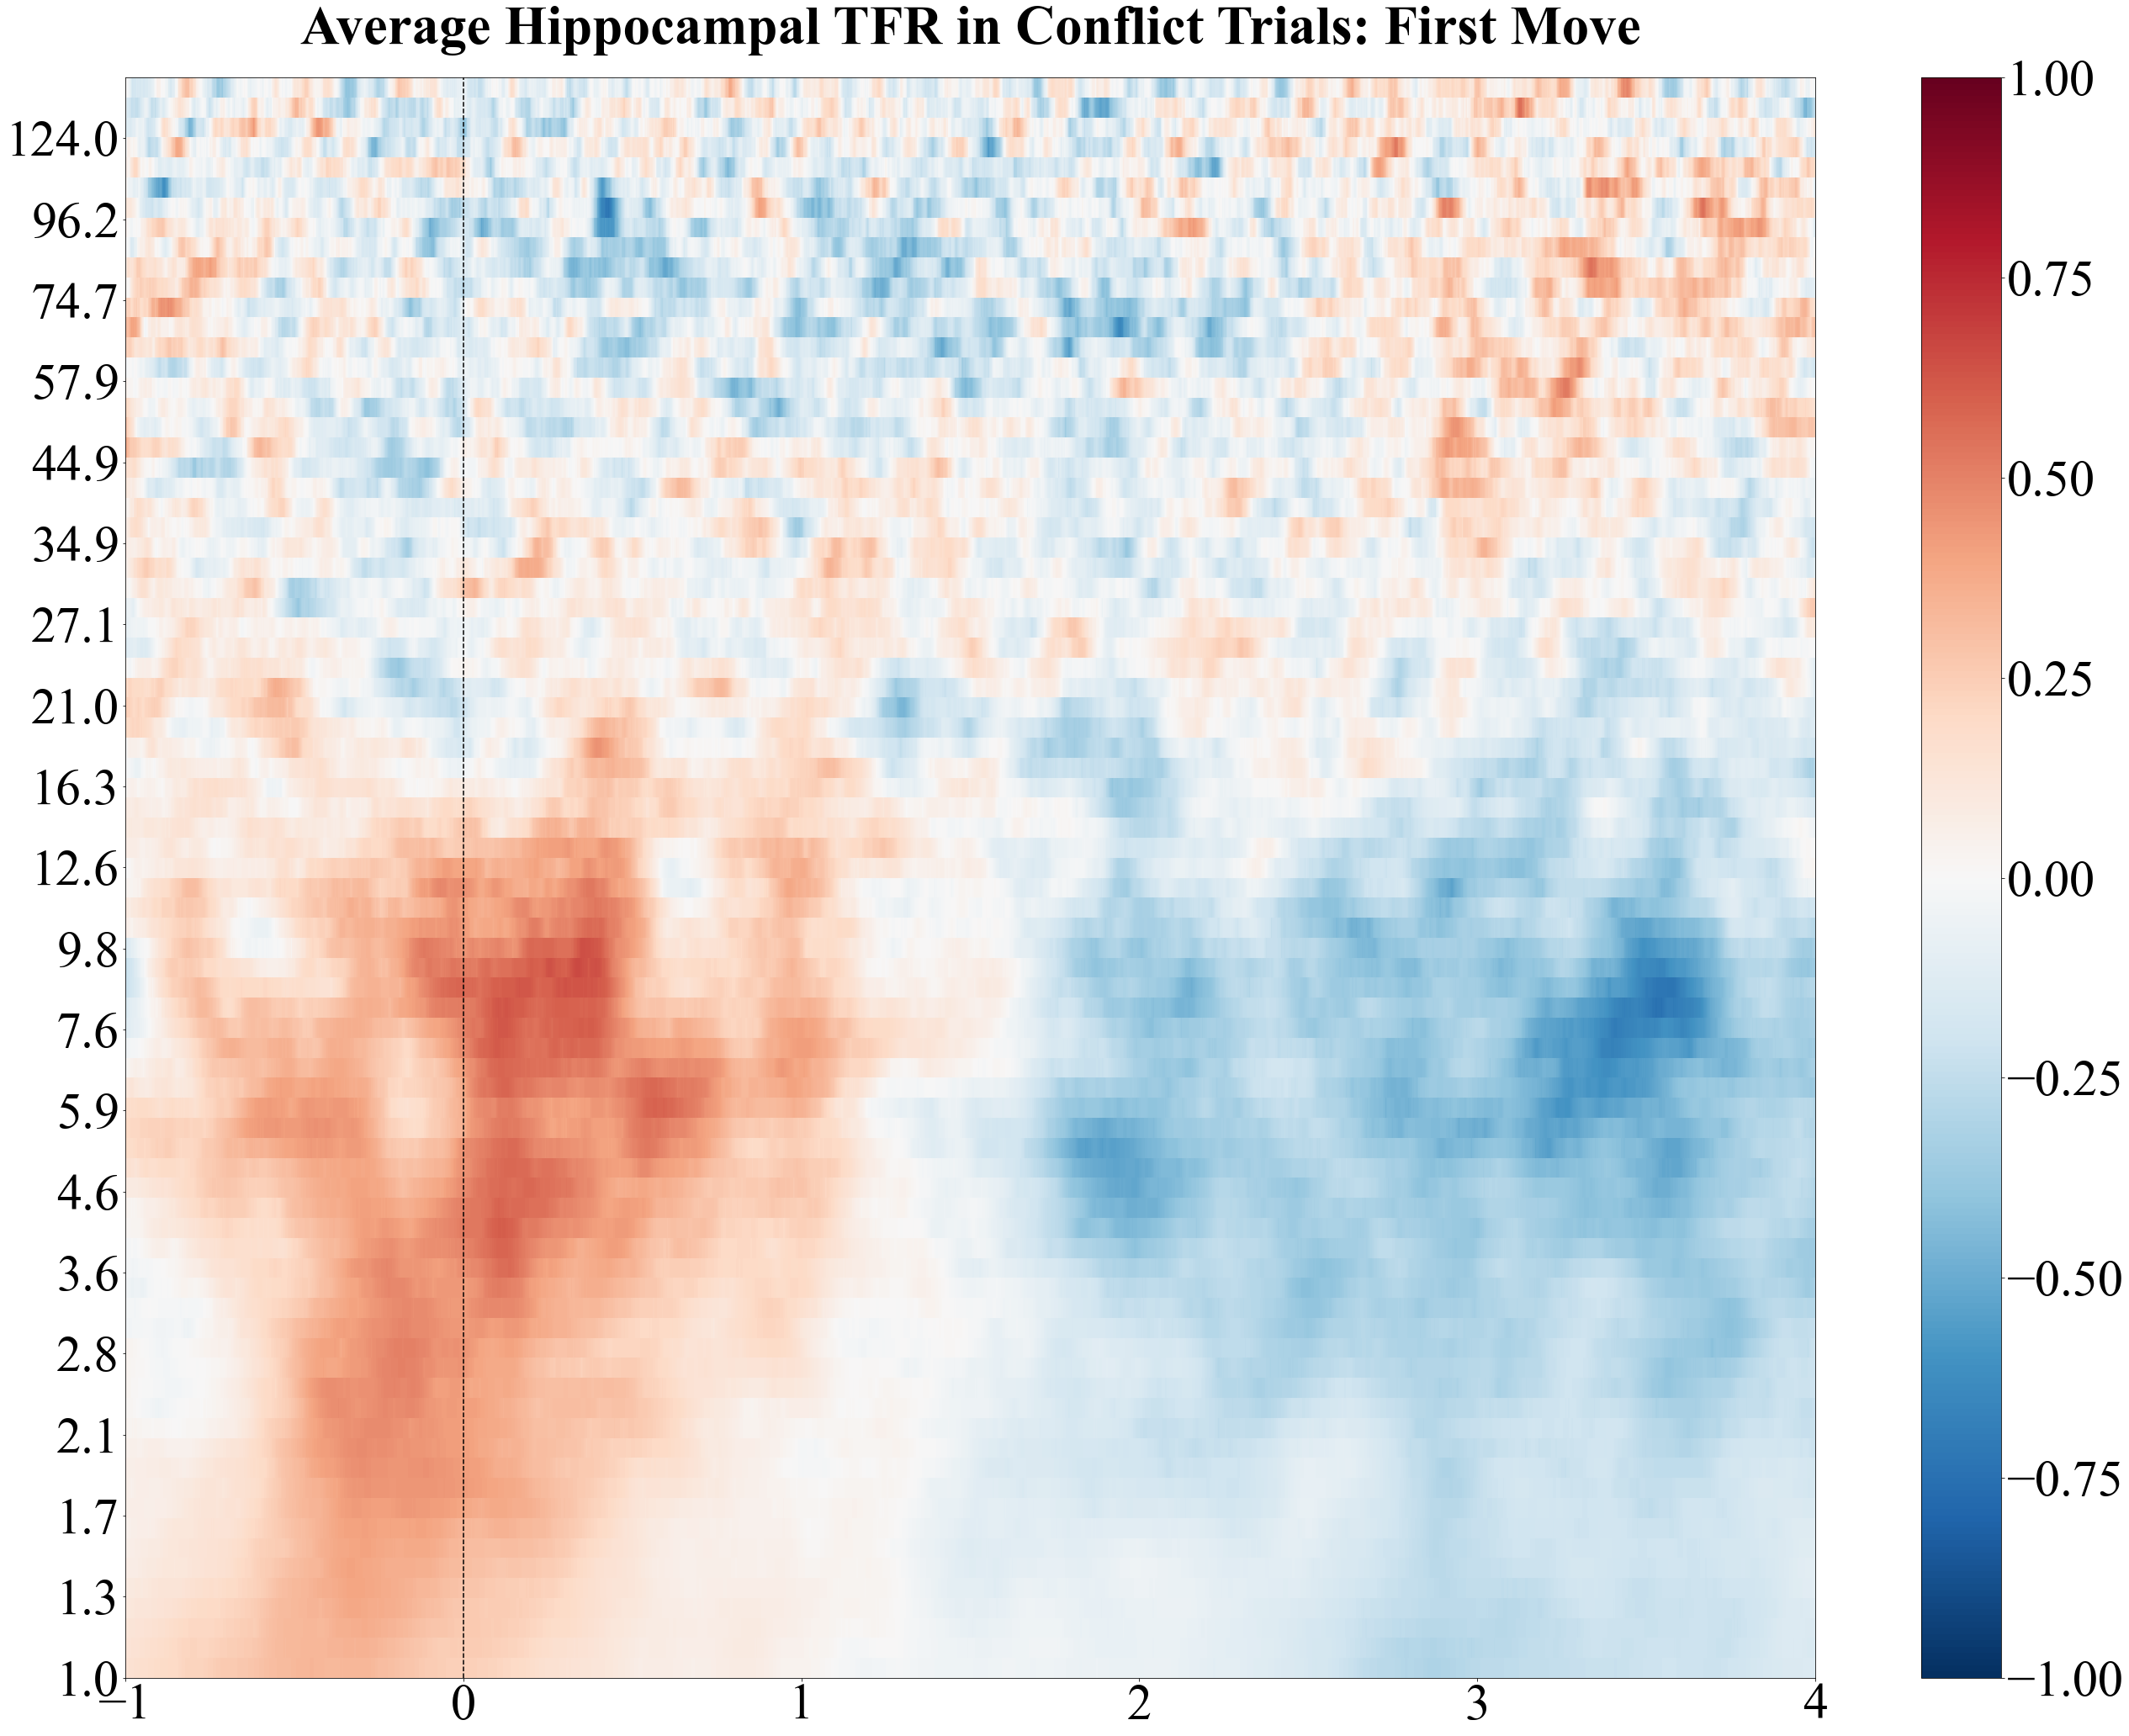

In [7]:
plot_allsub_averages(all_subs_average_hc_conflict, "Average Hippocampal TFR in Conflict Trials: First Move", 'average_hc_first_move_all_subs.png')

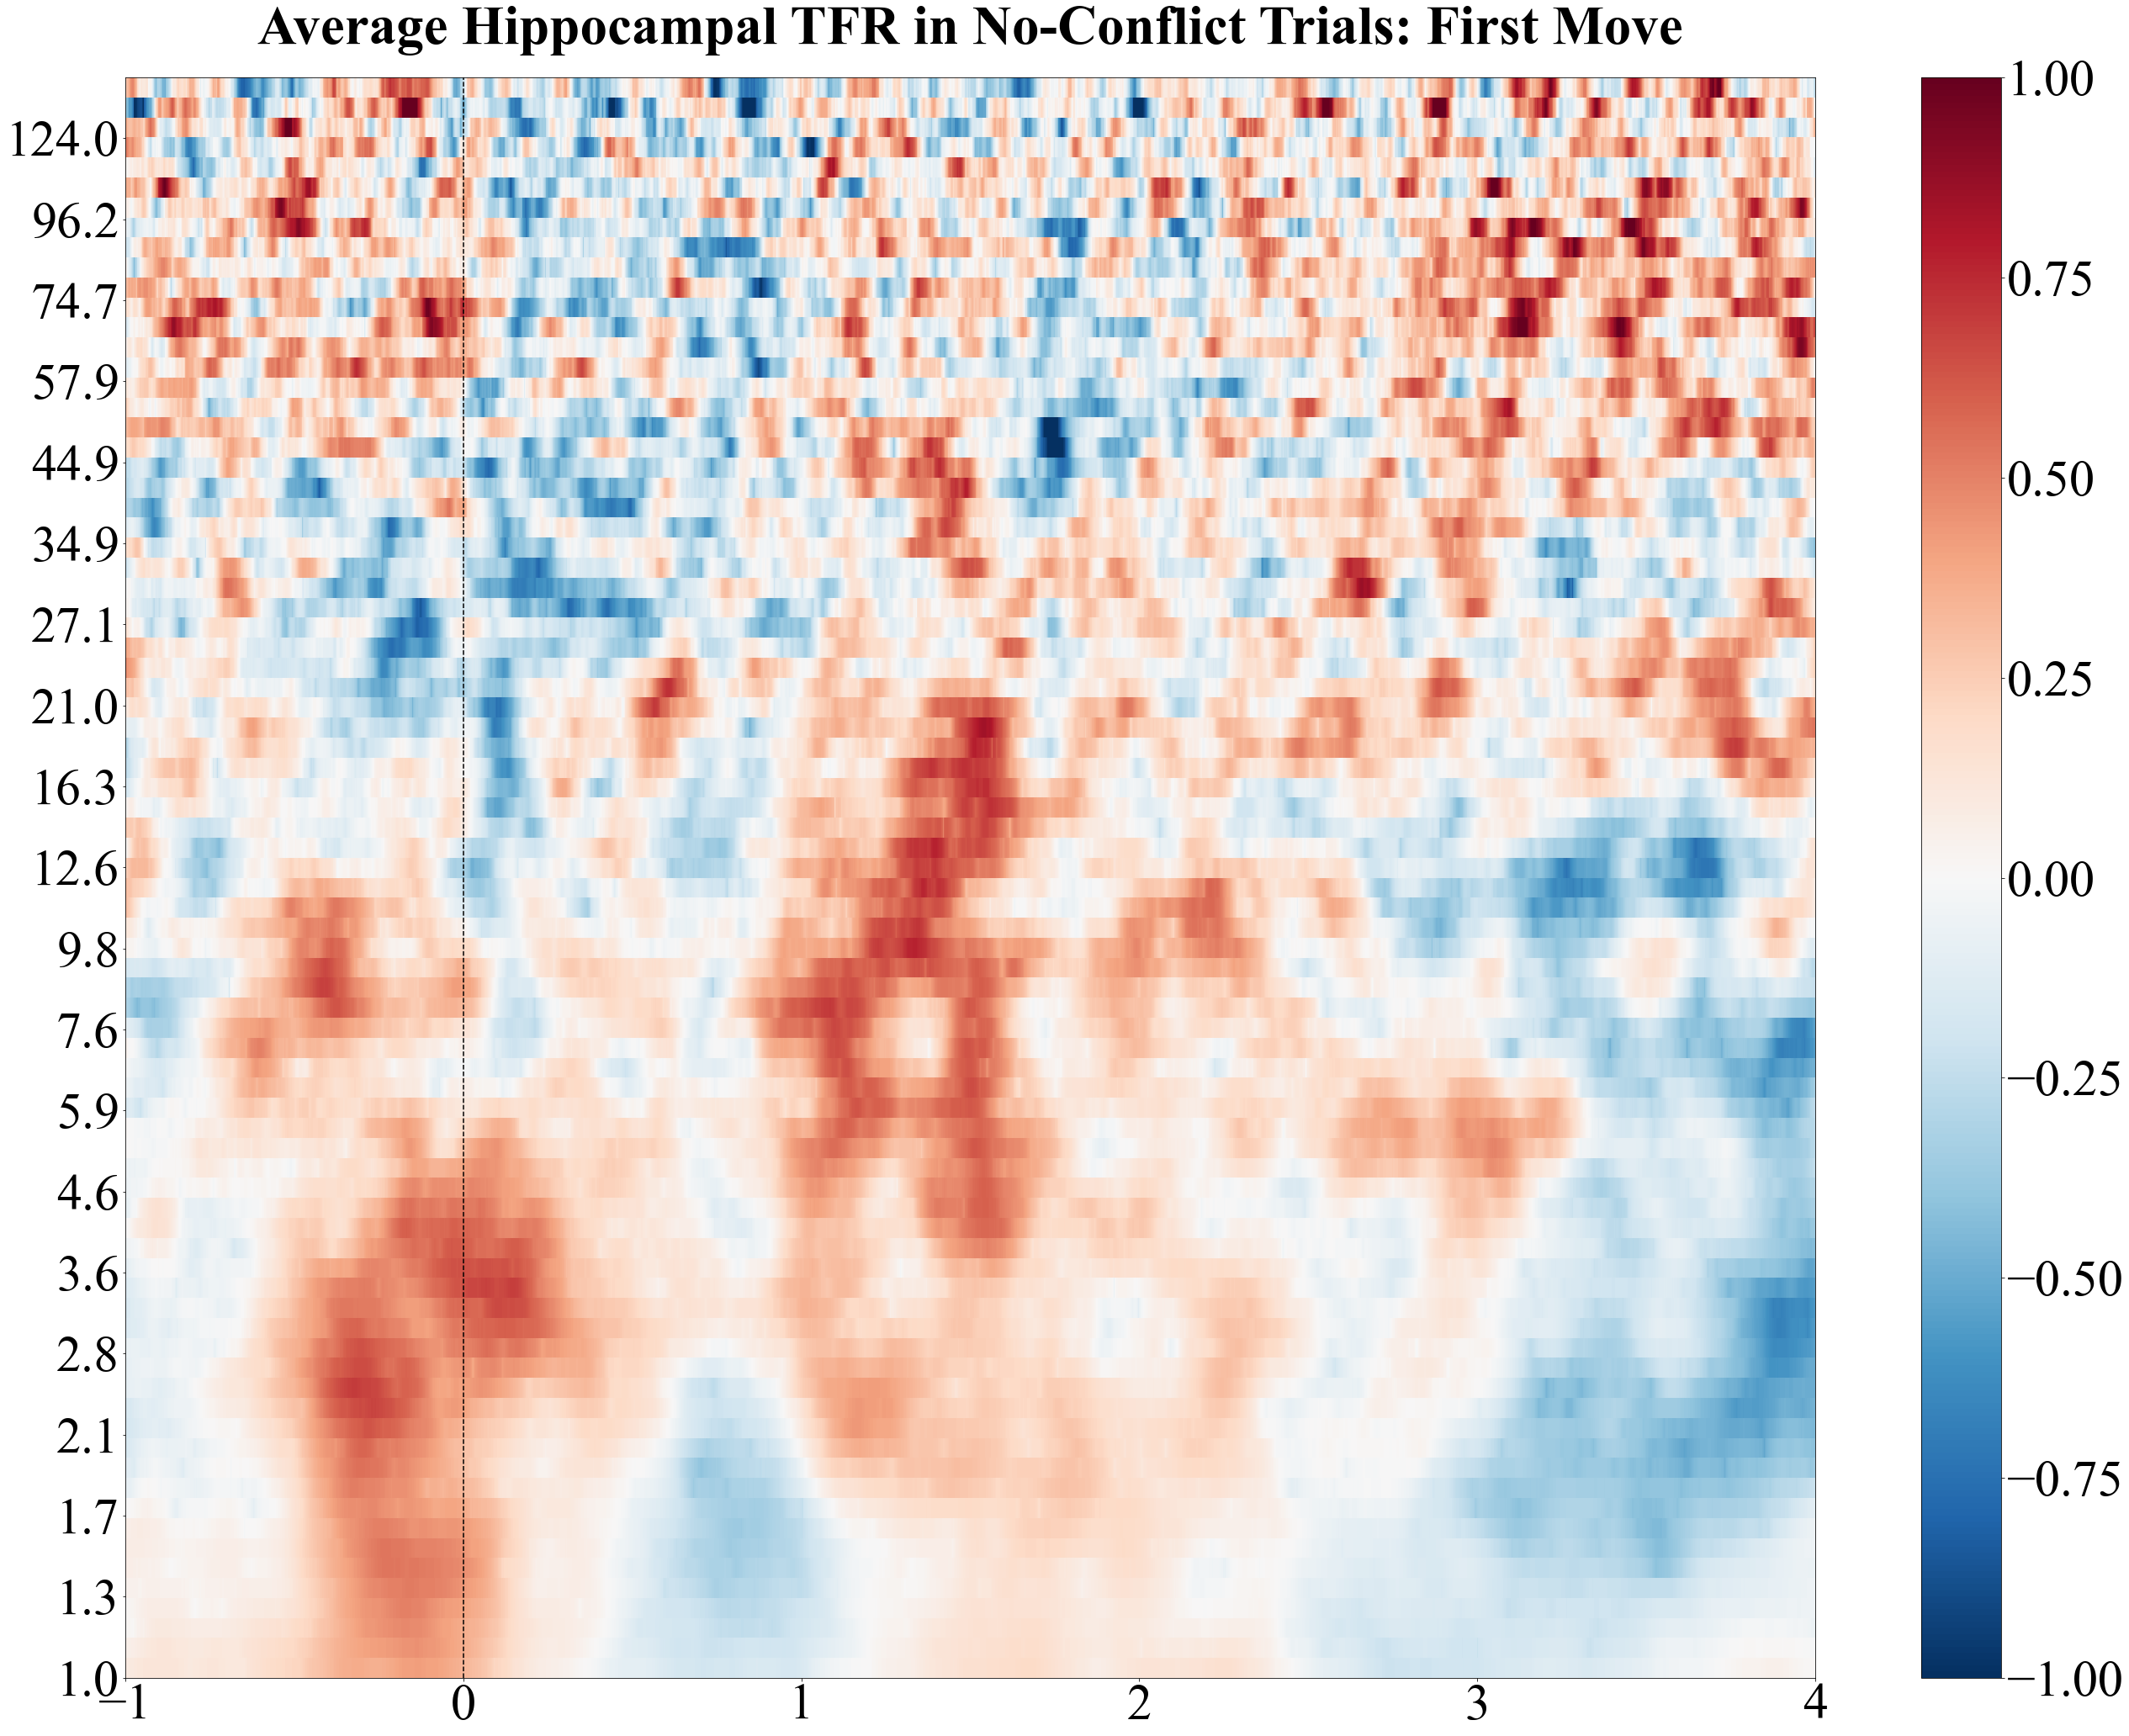

In [6]:
plot_allsub_averages(all_subs_average_hc_noconflict, "Average Hippocampal TFR in No-Conflict Trials: First Move", 'average_hc_first_move_noconflict_all_subs.png')

## OFC

In [7]:
all_subs_average_ofcs = calculate_first_move_average(sub_list, conditions, 'ofc')
all_subs_average_ofc_conflict = all_subs_average_ofcs[0]
all_subs_average_ofc_noconflict = all_subs_average_ofcs[1]


Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/first_move/ofc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/first_move/ofc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/first_move/ofc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/first_move/ofc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/first_move/

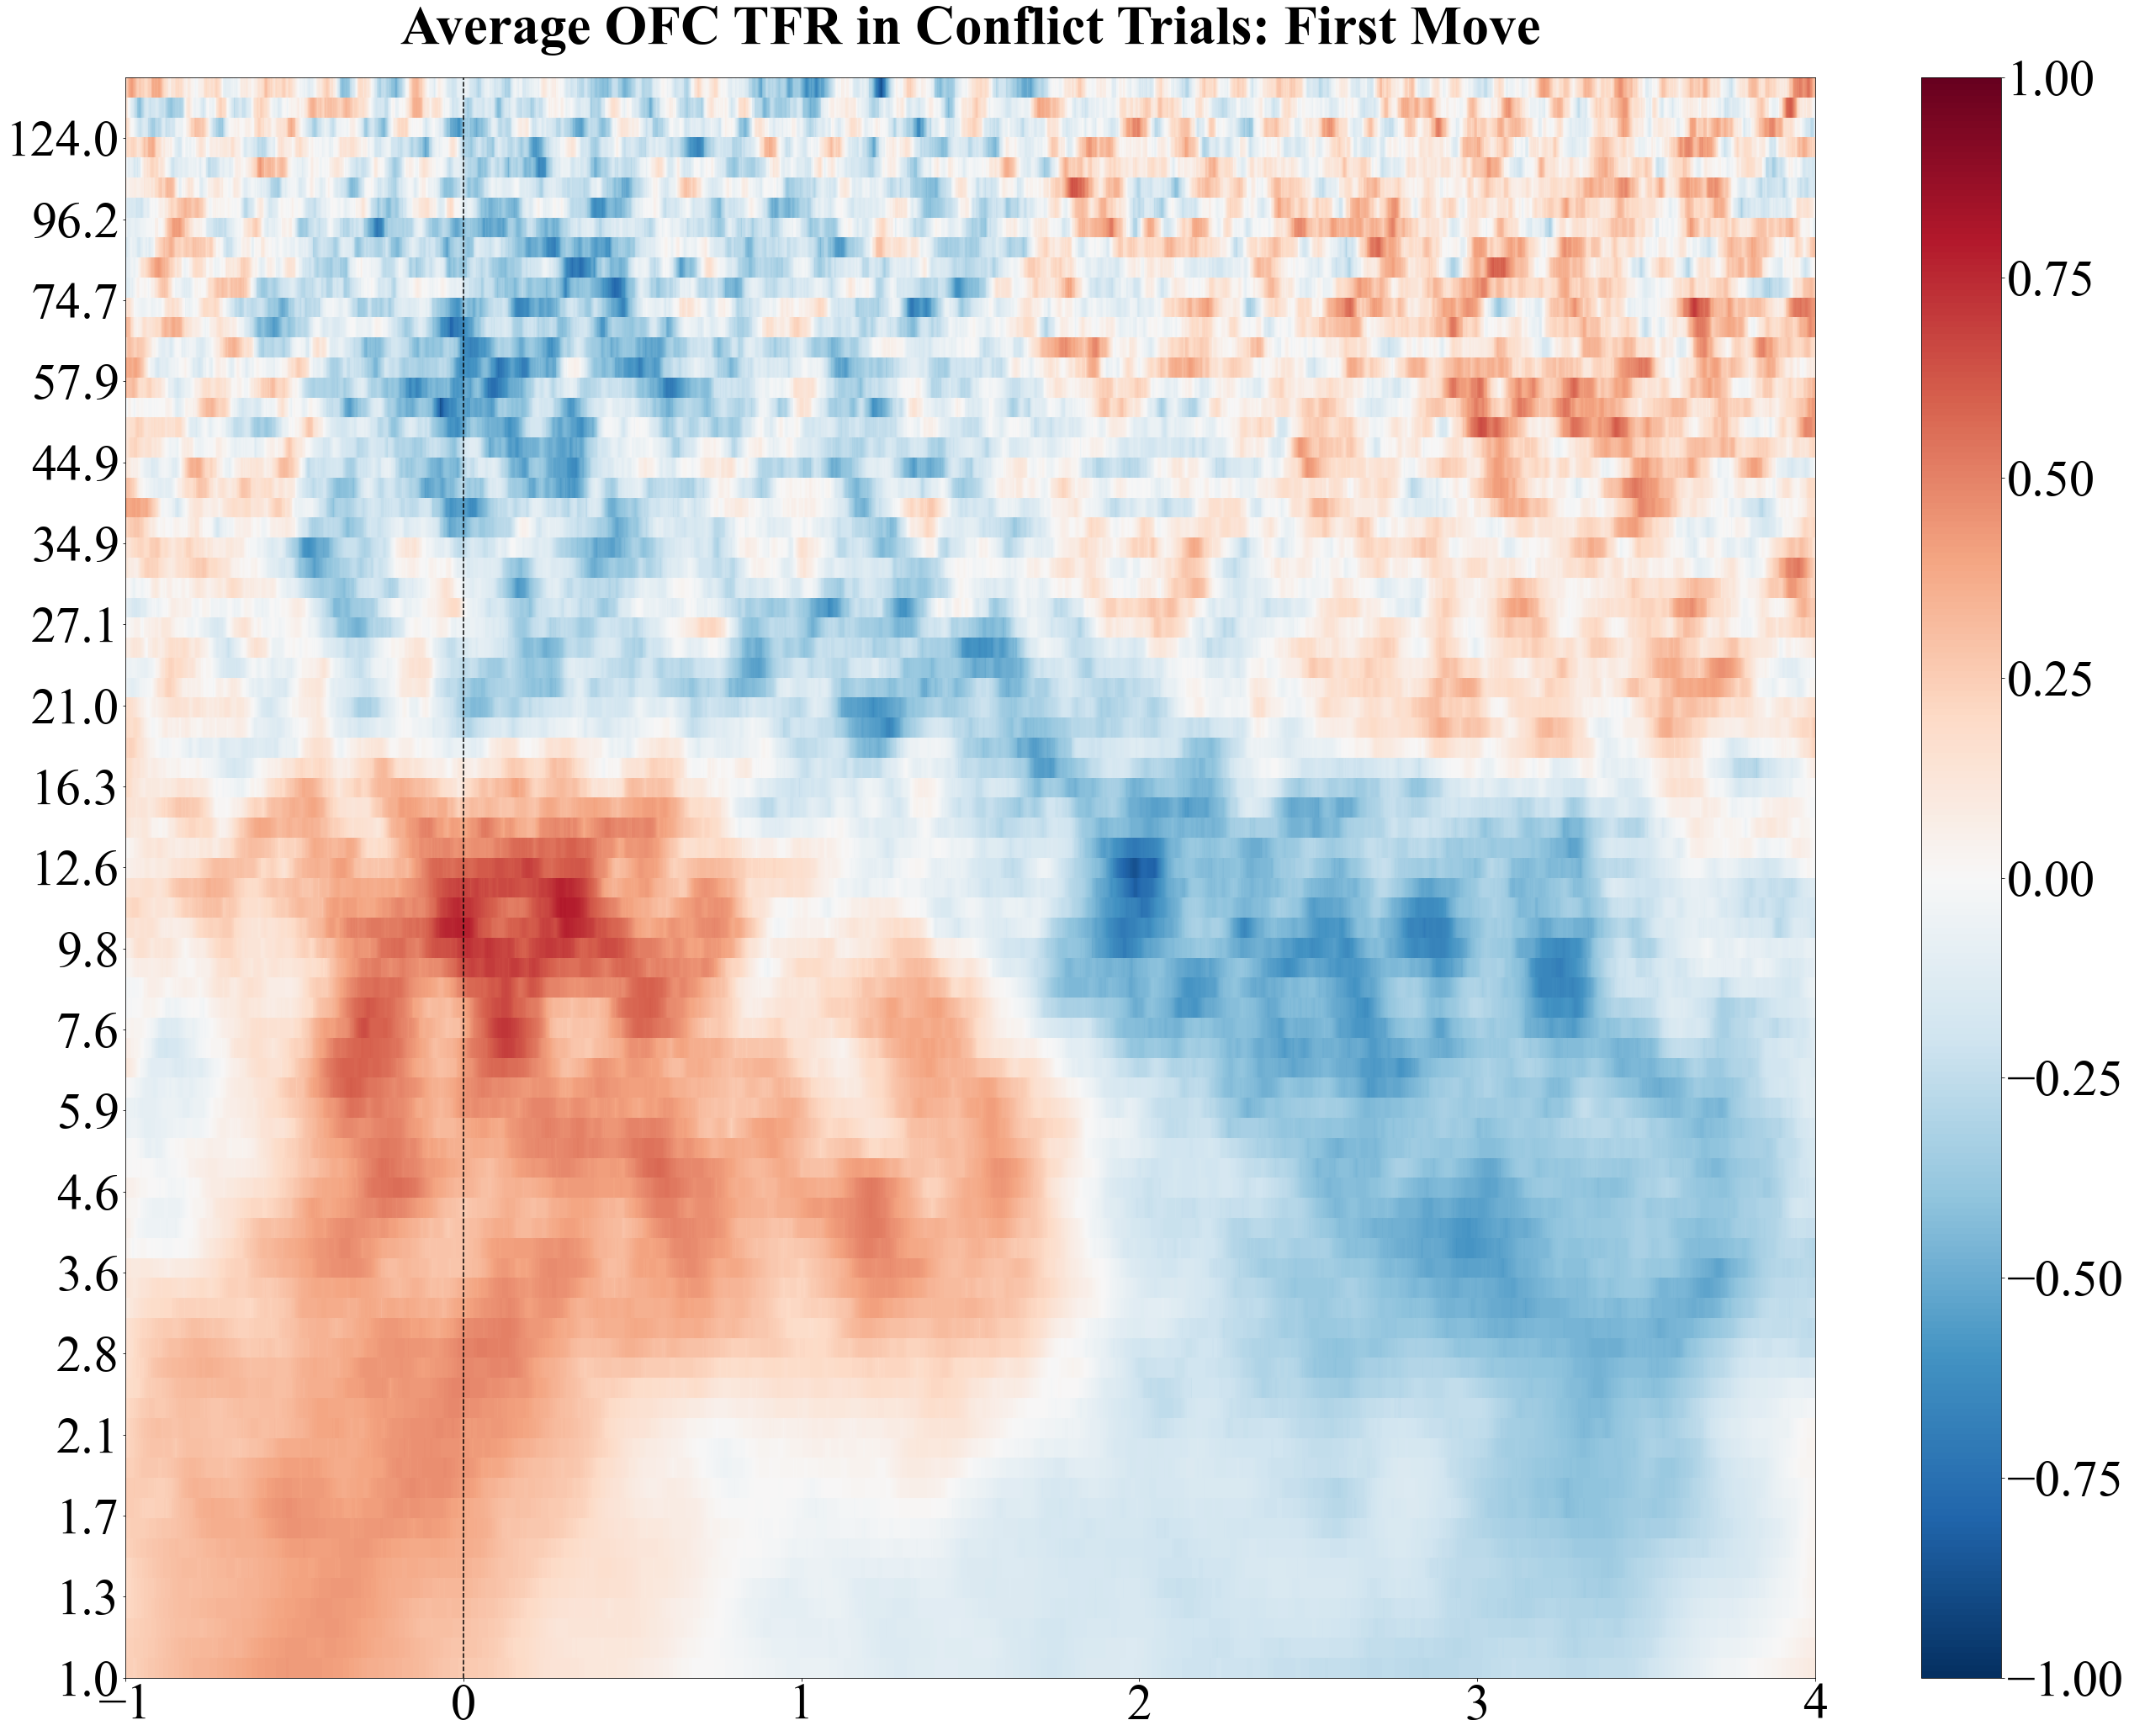

In [8]:
plot_allsub_averages(all_subs_average_ofc_conflict, "Average OFC TFR in Conflict Trials: First Move", 'average_ofc_first_move_all_subs.png')

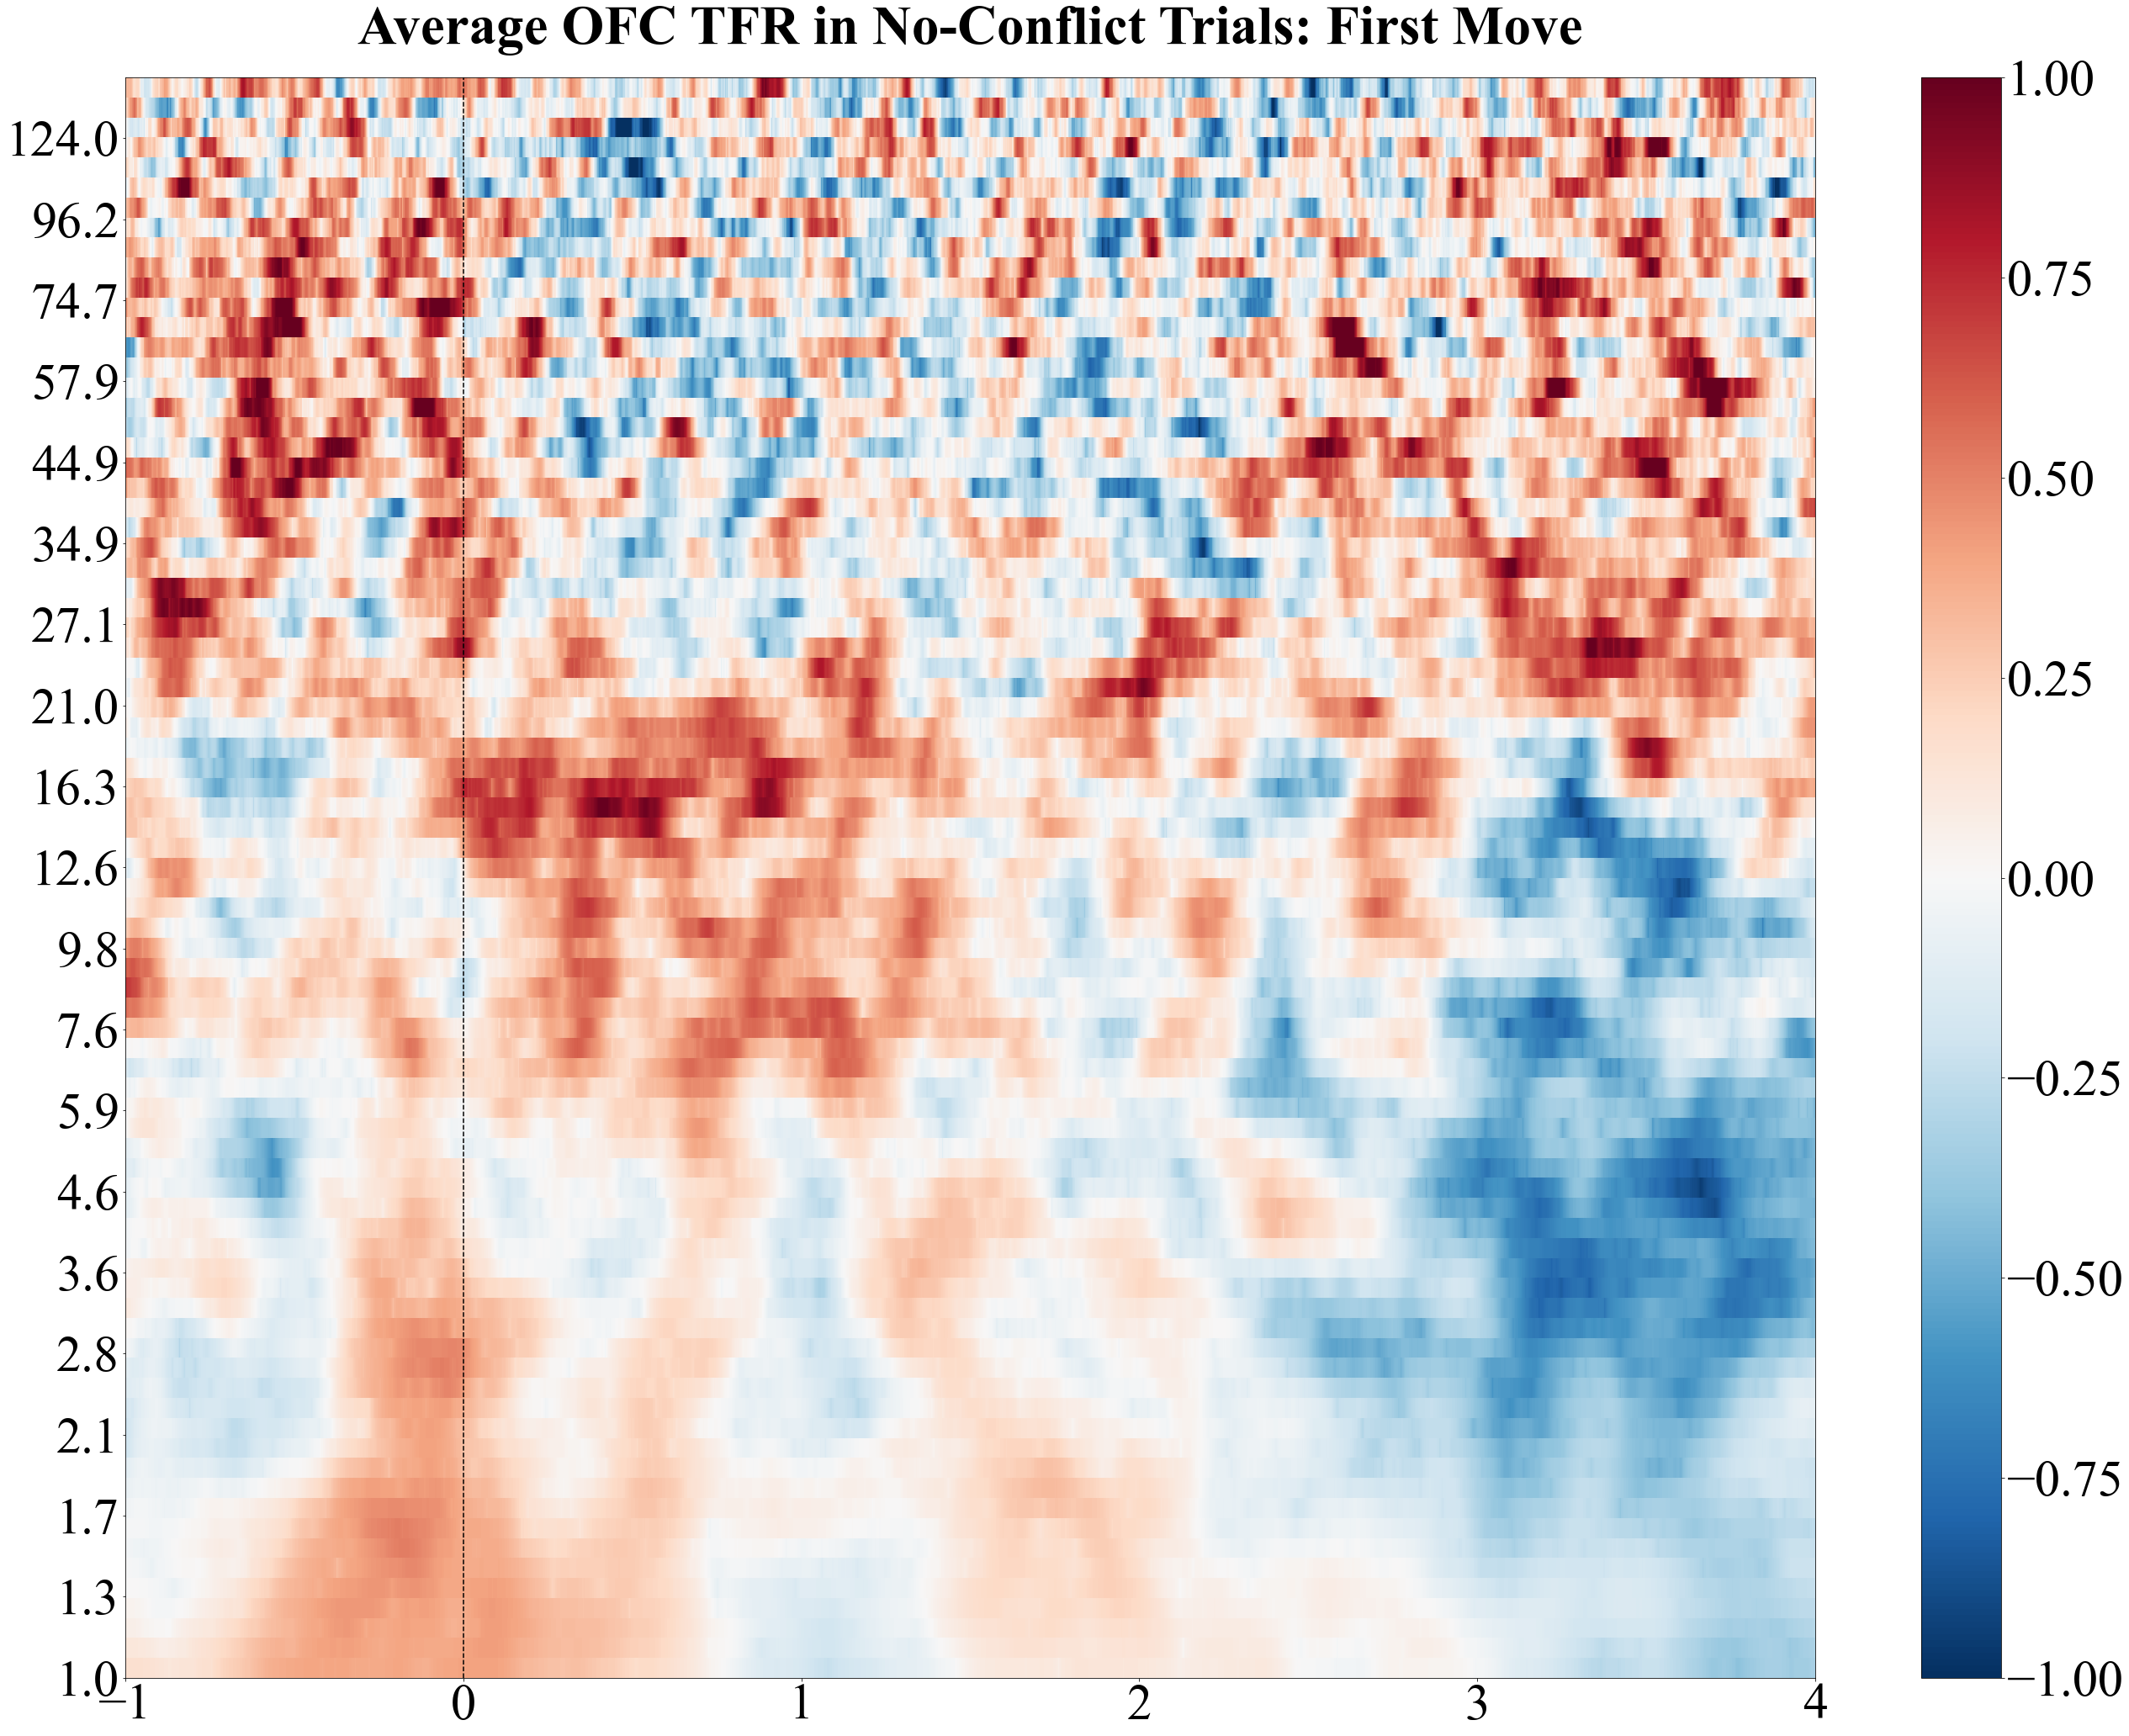

In [9]:
plot_allsub_averages(all_subs_average_ofc_noconflict, "Average OFC TFR in No-Conflict Trials: First Move", 'average_ofc_first_move_noconflict_all_subs.png')

## Anterior Cingulate

In [10]:
all_subs_average_cings = calculate_first_move_average(sub_list, conditions, 'cing')
all_subs_average_cing_conflict = all_subs_average_cings[0]
all_subs_average_cing_noconflict = all_subs_average_cings[1]


Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/first_move/cing-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/first_move/cing-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/first_move/cing-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/first_move/cing-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/first_m

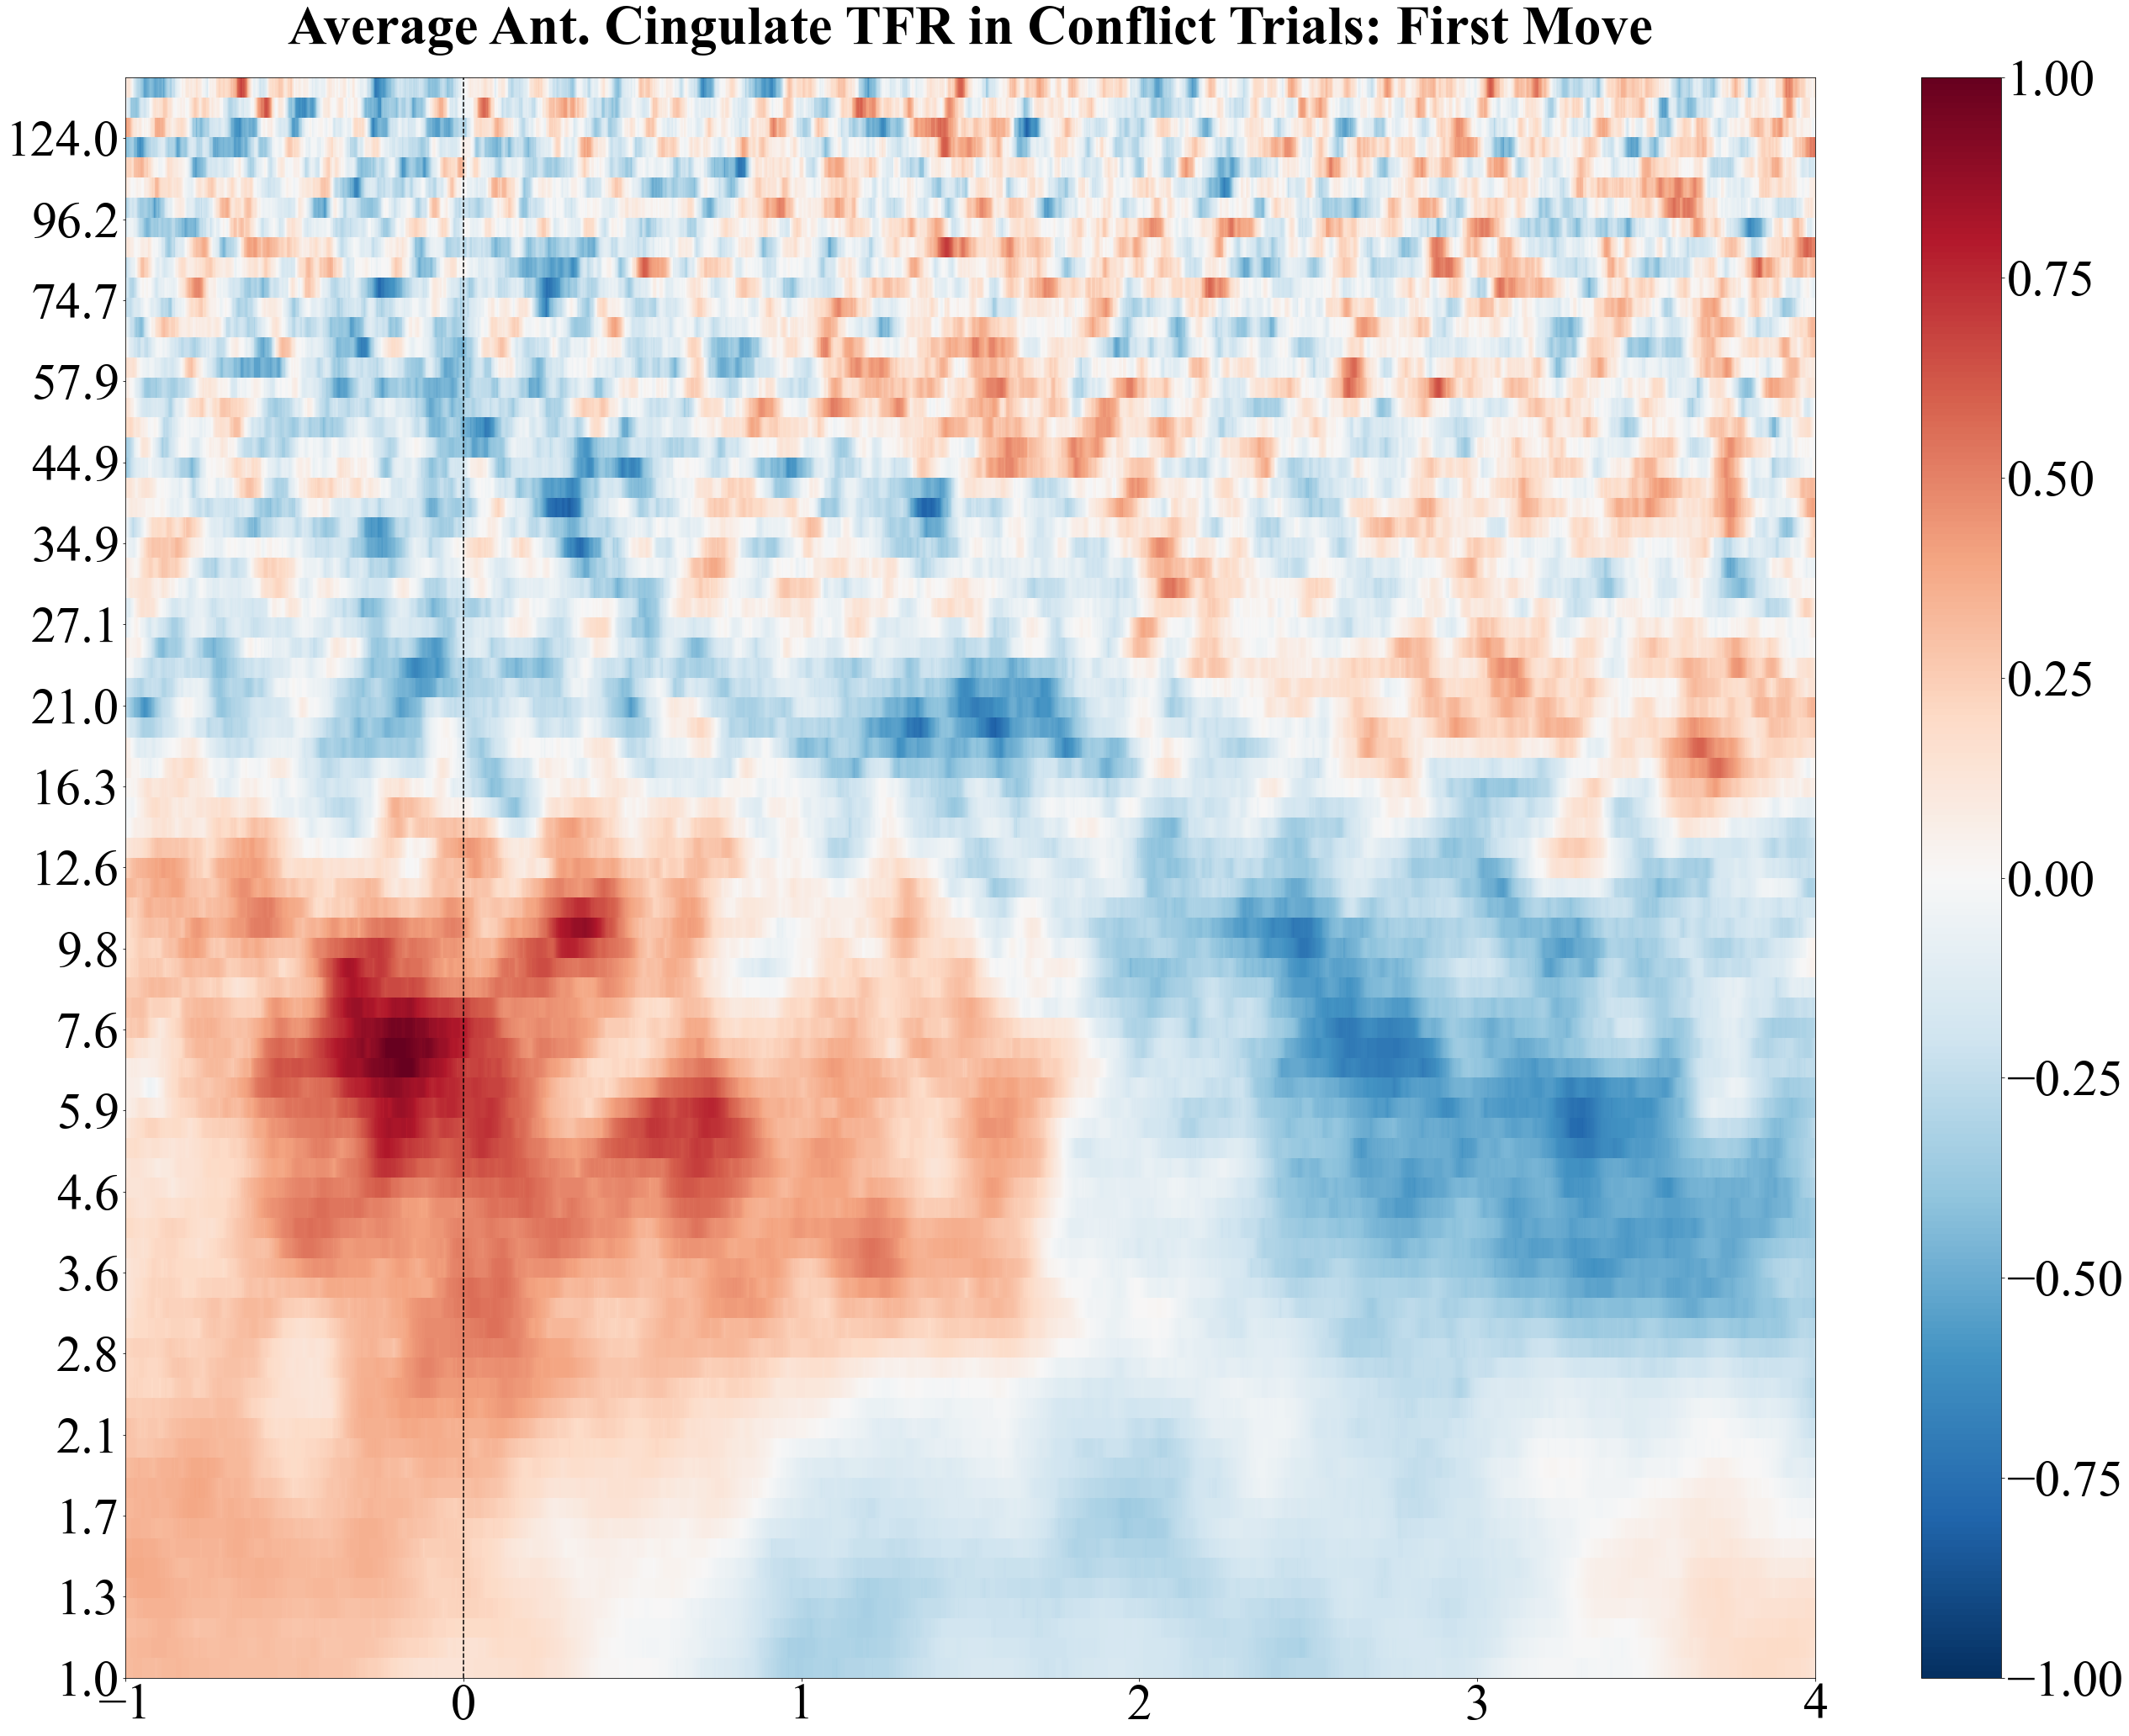

In [11]:
plot_allsub_averages(all_subs_average_cing_conflict, "Average Ant. Cingulate TFR in Conflict Trials: First Move", 'average_cing_first_move_all_subs.png')

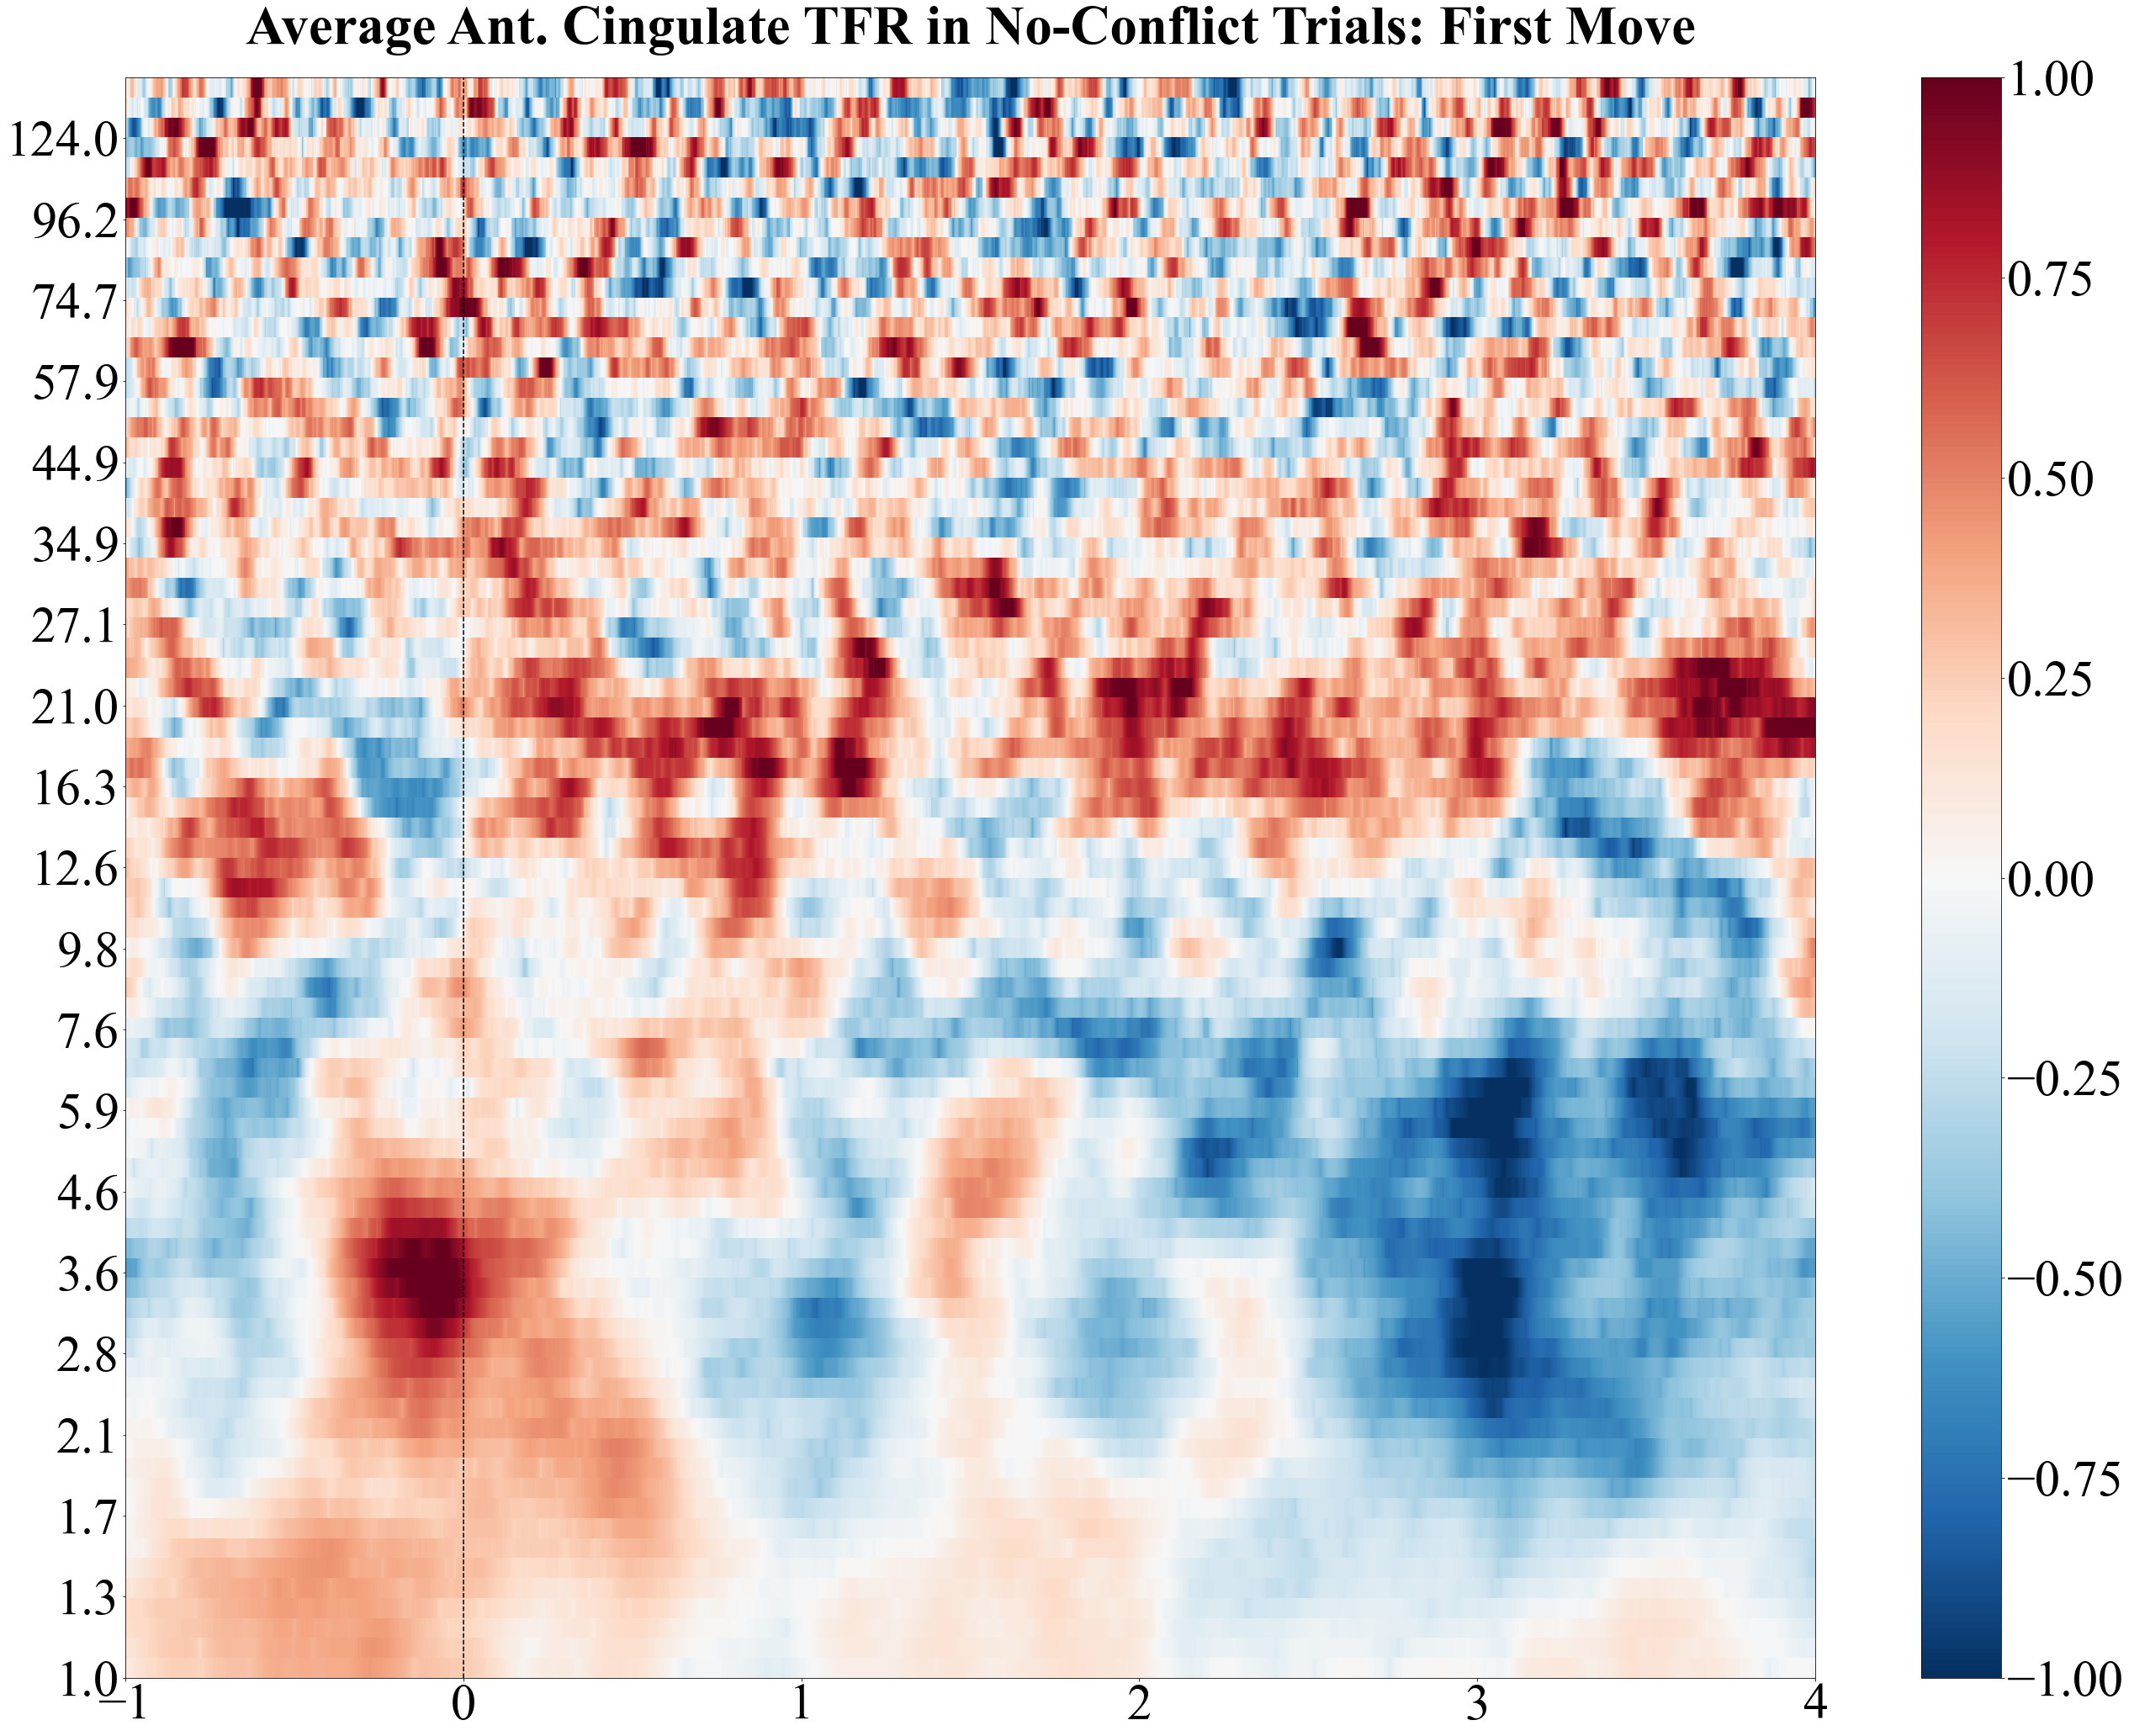

In [12]:
plot_allsub_averages(all_subs_average_cing_noconflict, "Average Ant. Cingulate TFR in No-Conflict Trials: First Move", 'average_cing_first_move_noconflict_all_subs.png')

## Amygdala

In [13]:
all_subs_average_amygs = calculate_first_move_average(sub_list, conditions, 'amyg')
all_subs_average_amyg_conflict = all_subs_average_amygs[0]
all_subs_average_amyg_noconflict = all_subs_average_amygs[1]


Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/first_move/amyg-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/first_move/amyg-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/first_move/amyg-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/first_move/amyg-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/first_m

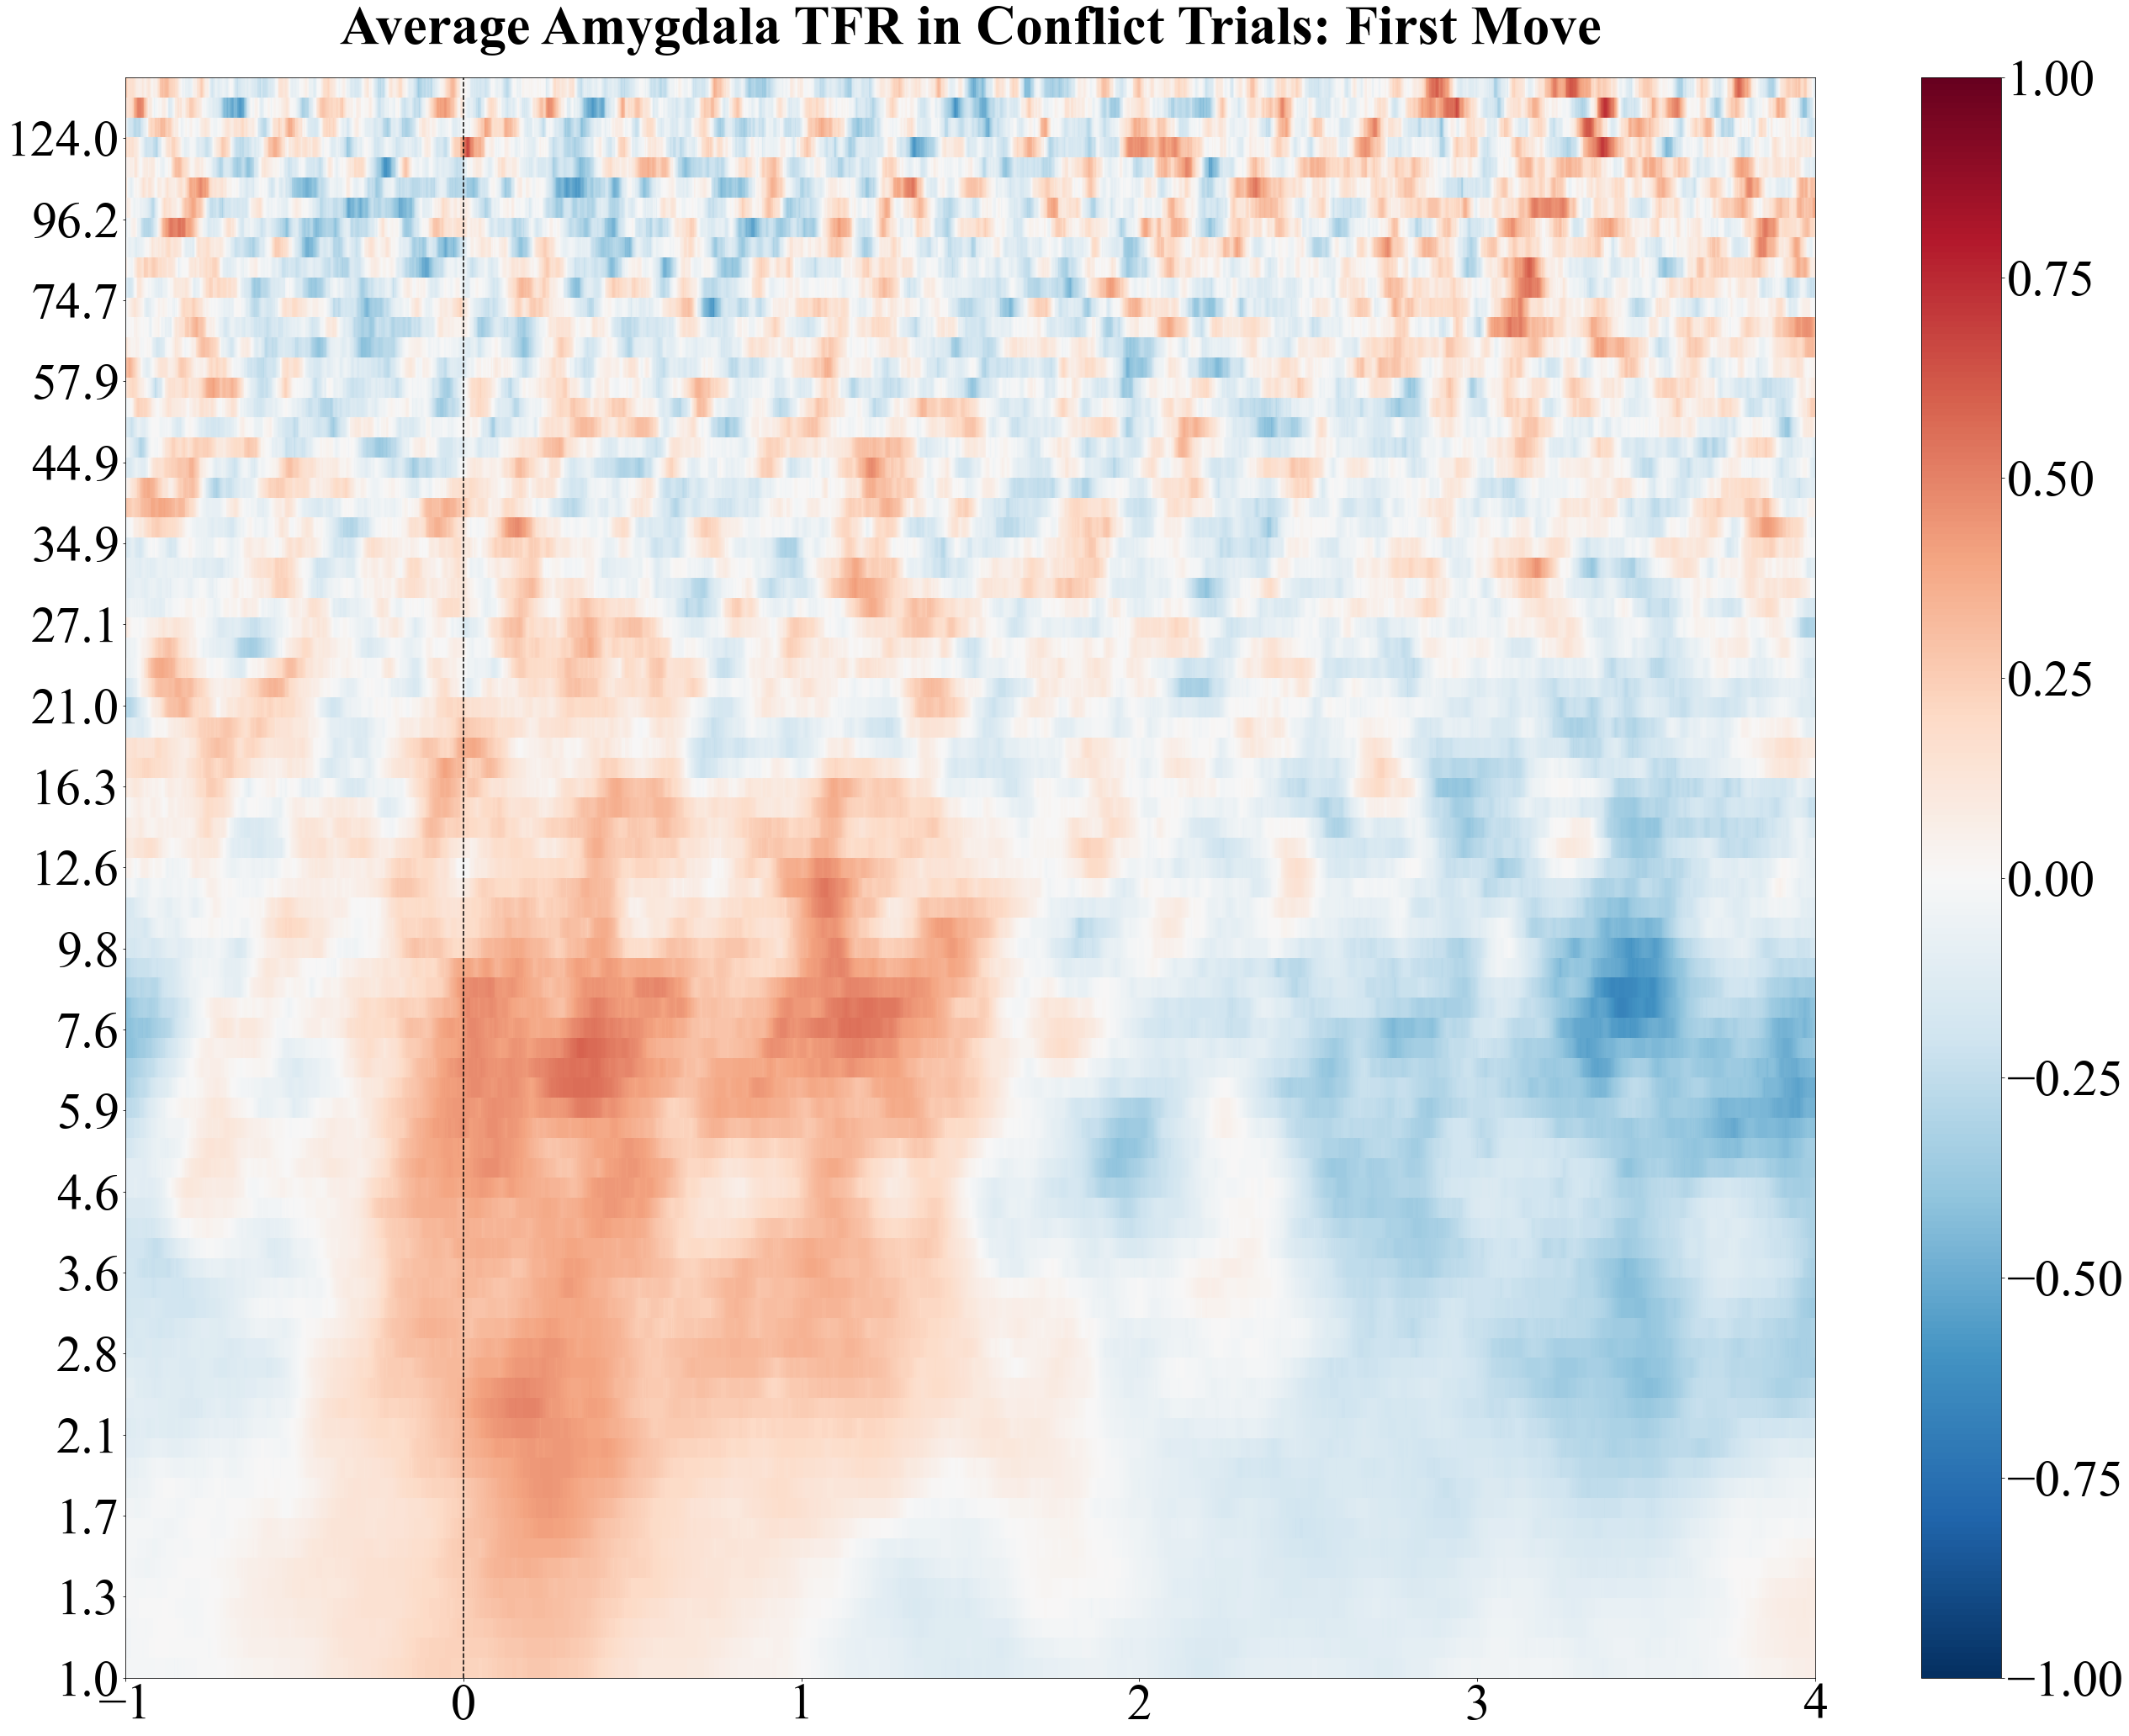

In [14]:
plot_allsub_averages(all_subs_average_amyg_conflict, "Average Amygdala TFR in Conflict Trials: First Move", 'average_amyg_first_move_all_subs.png')

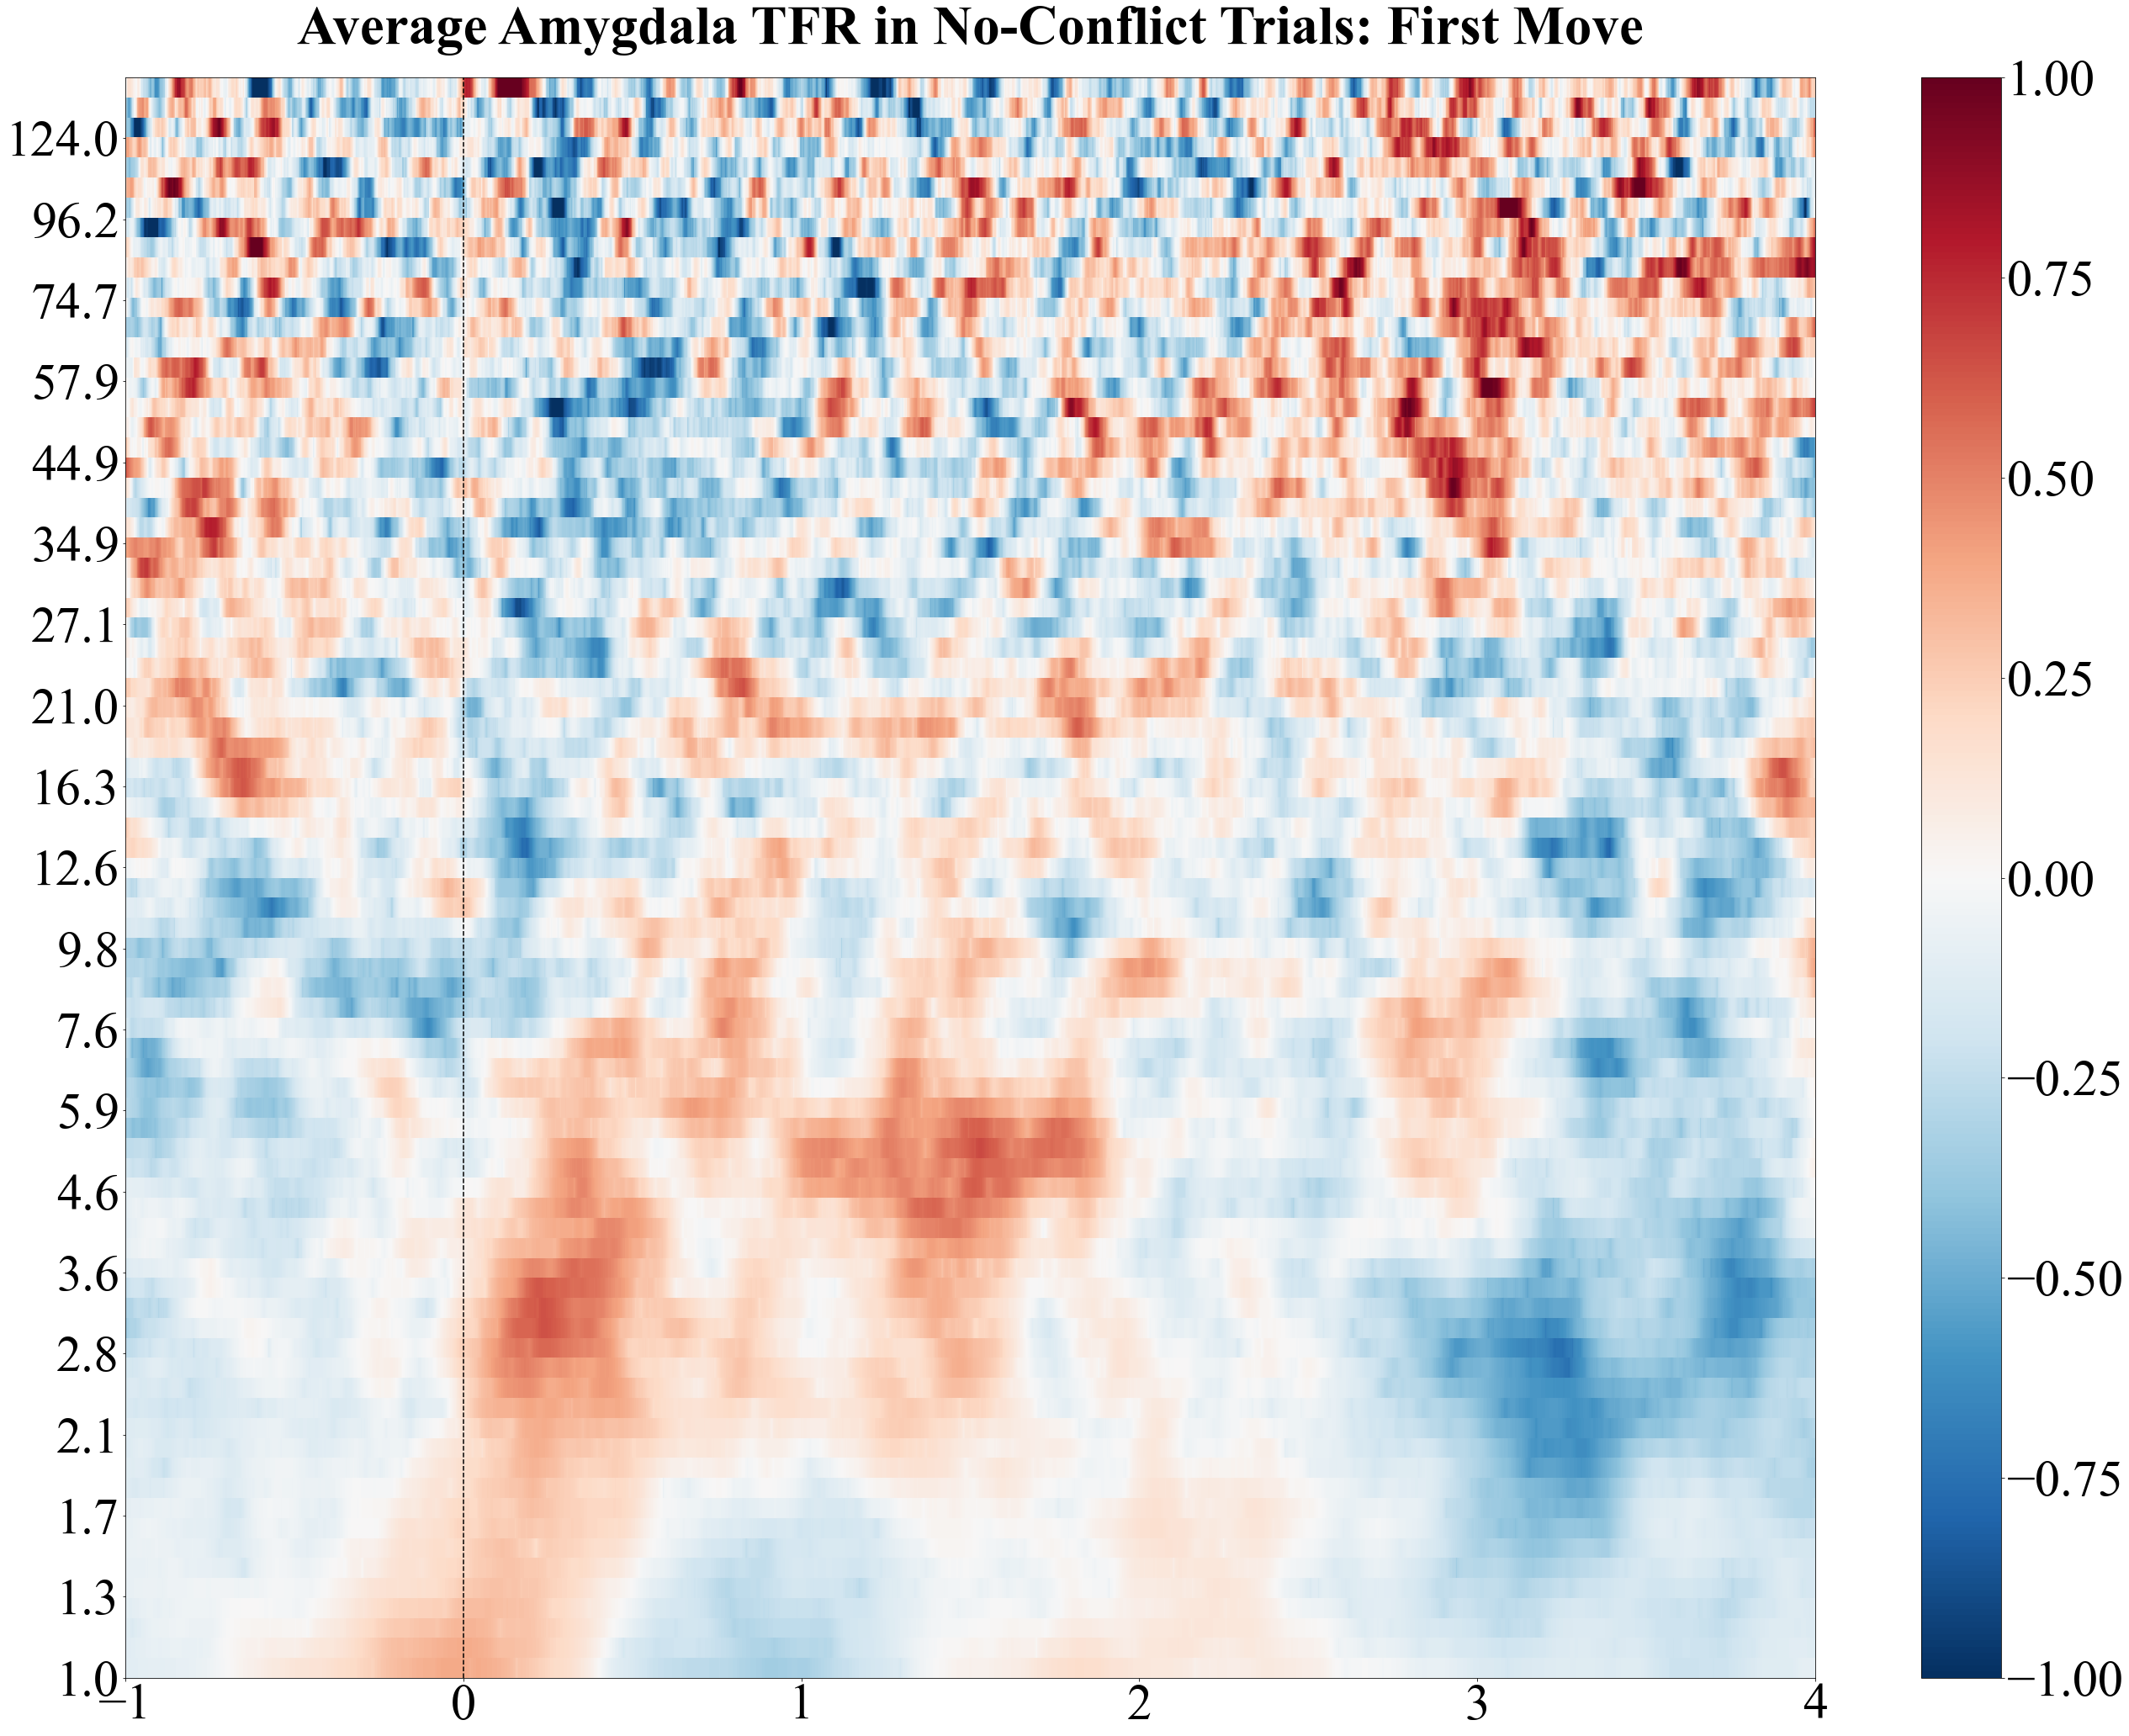

In [15]:
plot_allsub_averages(all_subs_average_amyg_noconflict, "Average Amygdala TFR in No-Conflict Trials: First Move", 'average_amyg_first_move_noconflict_all_subs.png')

# Other Regions

## dlPFC

In [16]:
all_subs_average_dlpfcs = calculate_first_move_average(sub_list, conditions, 'dlpfc')
all_subs_average_dlpfc_conflict = all_subs_average_dlpfcs[0]
all_subs_average_dlpfc_noconflict = all_subs_average_dlpfcs[1]


Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/first_move/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/first_move/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/first_move/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/first_move/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/fir

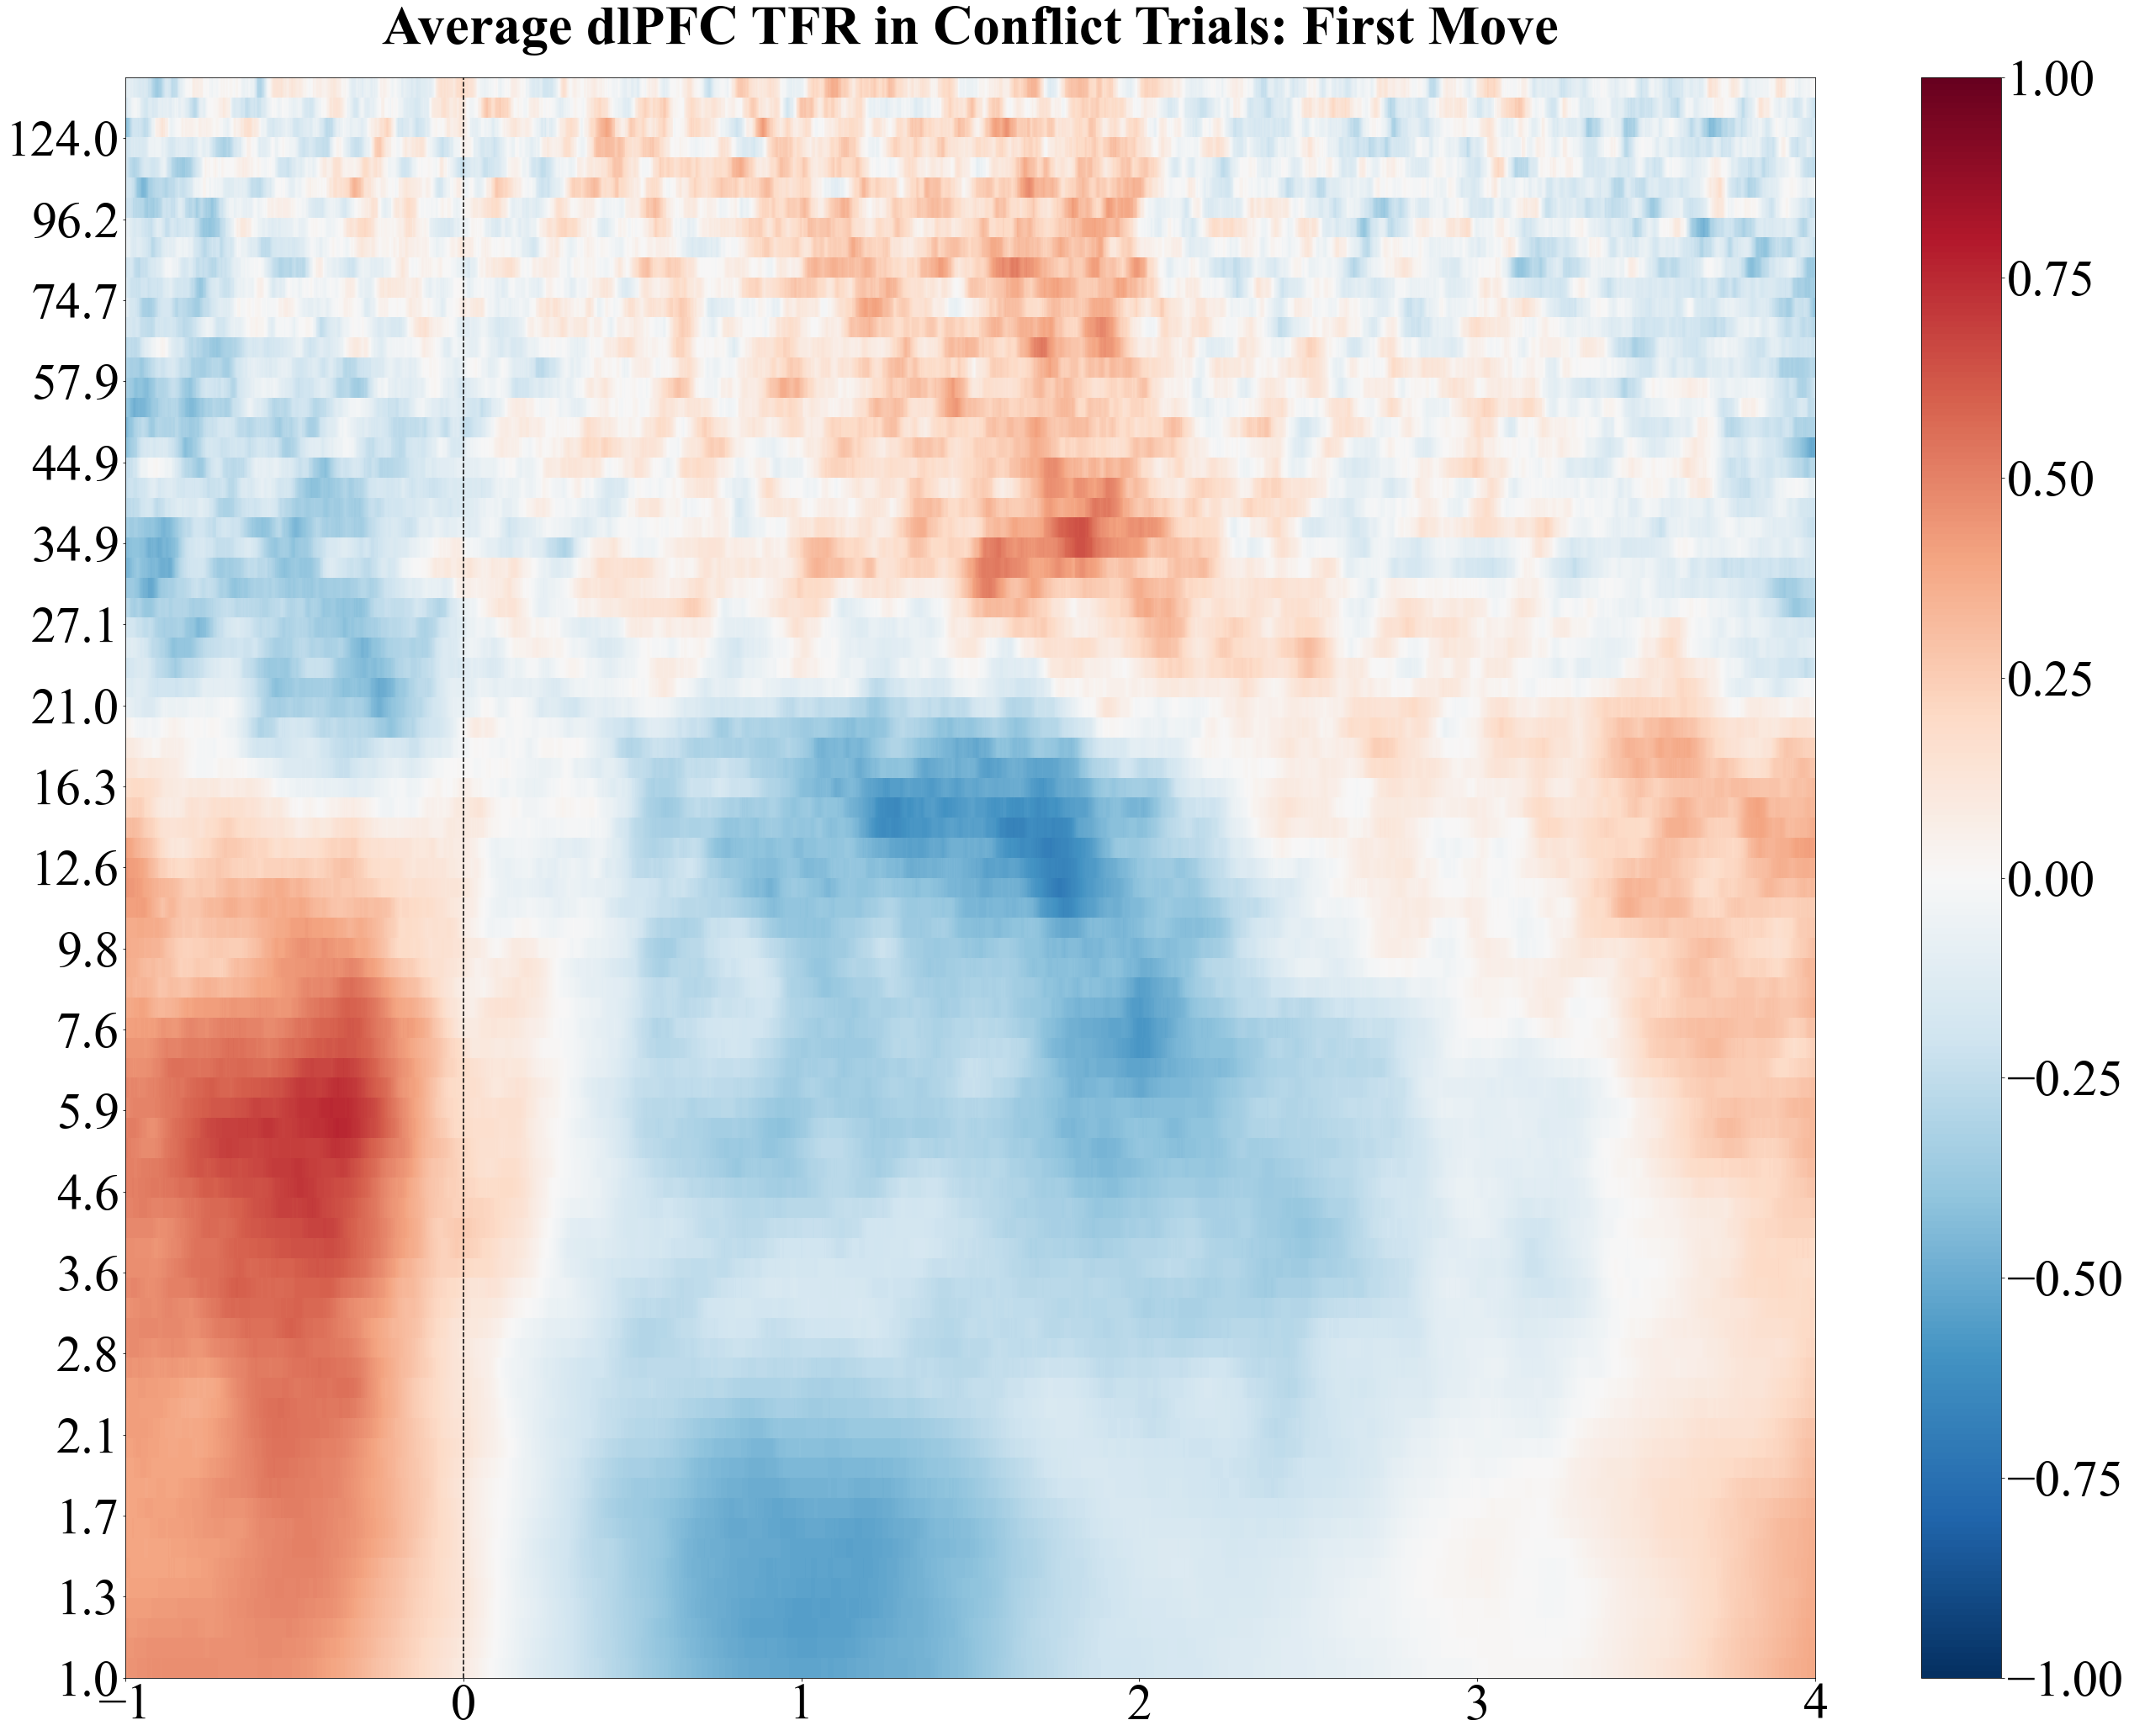

In [17]:
plot_allsub_averages(all_subs_average_dlpfc_conflict, "Average dlPFC TFR in Conflict Trials: First Move", 'average_dlpfc_first_move_all_subs.png')

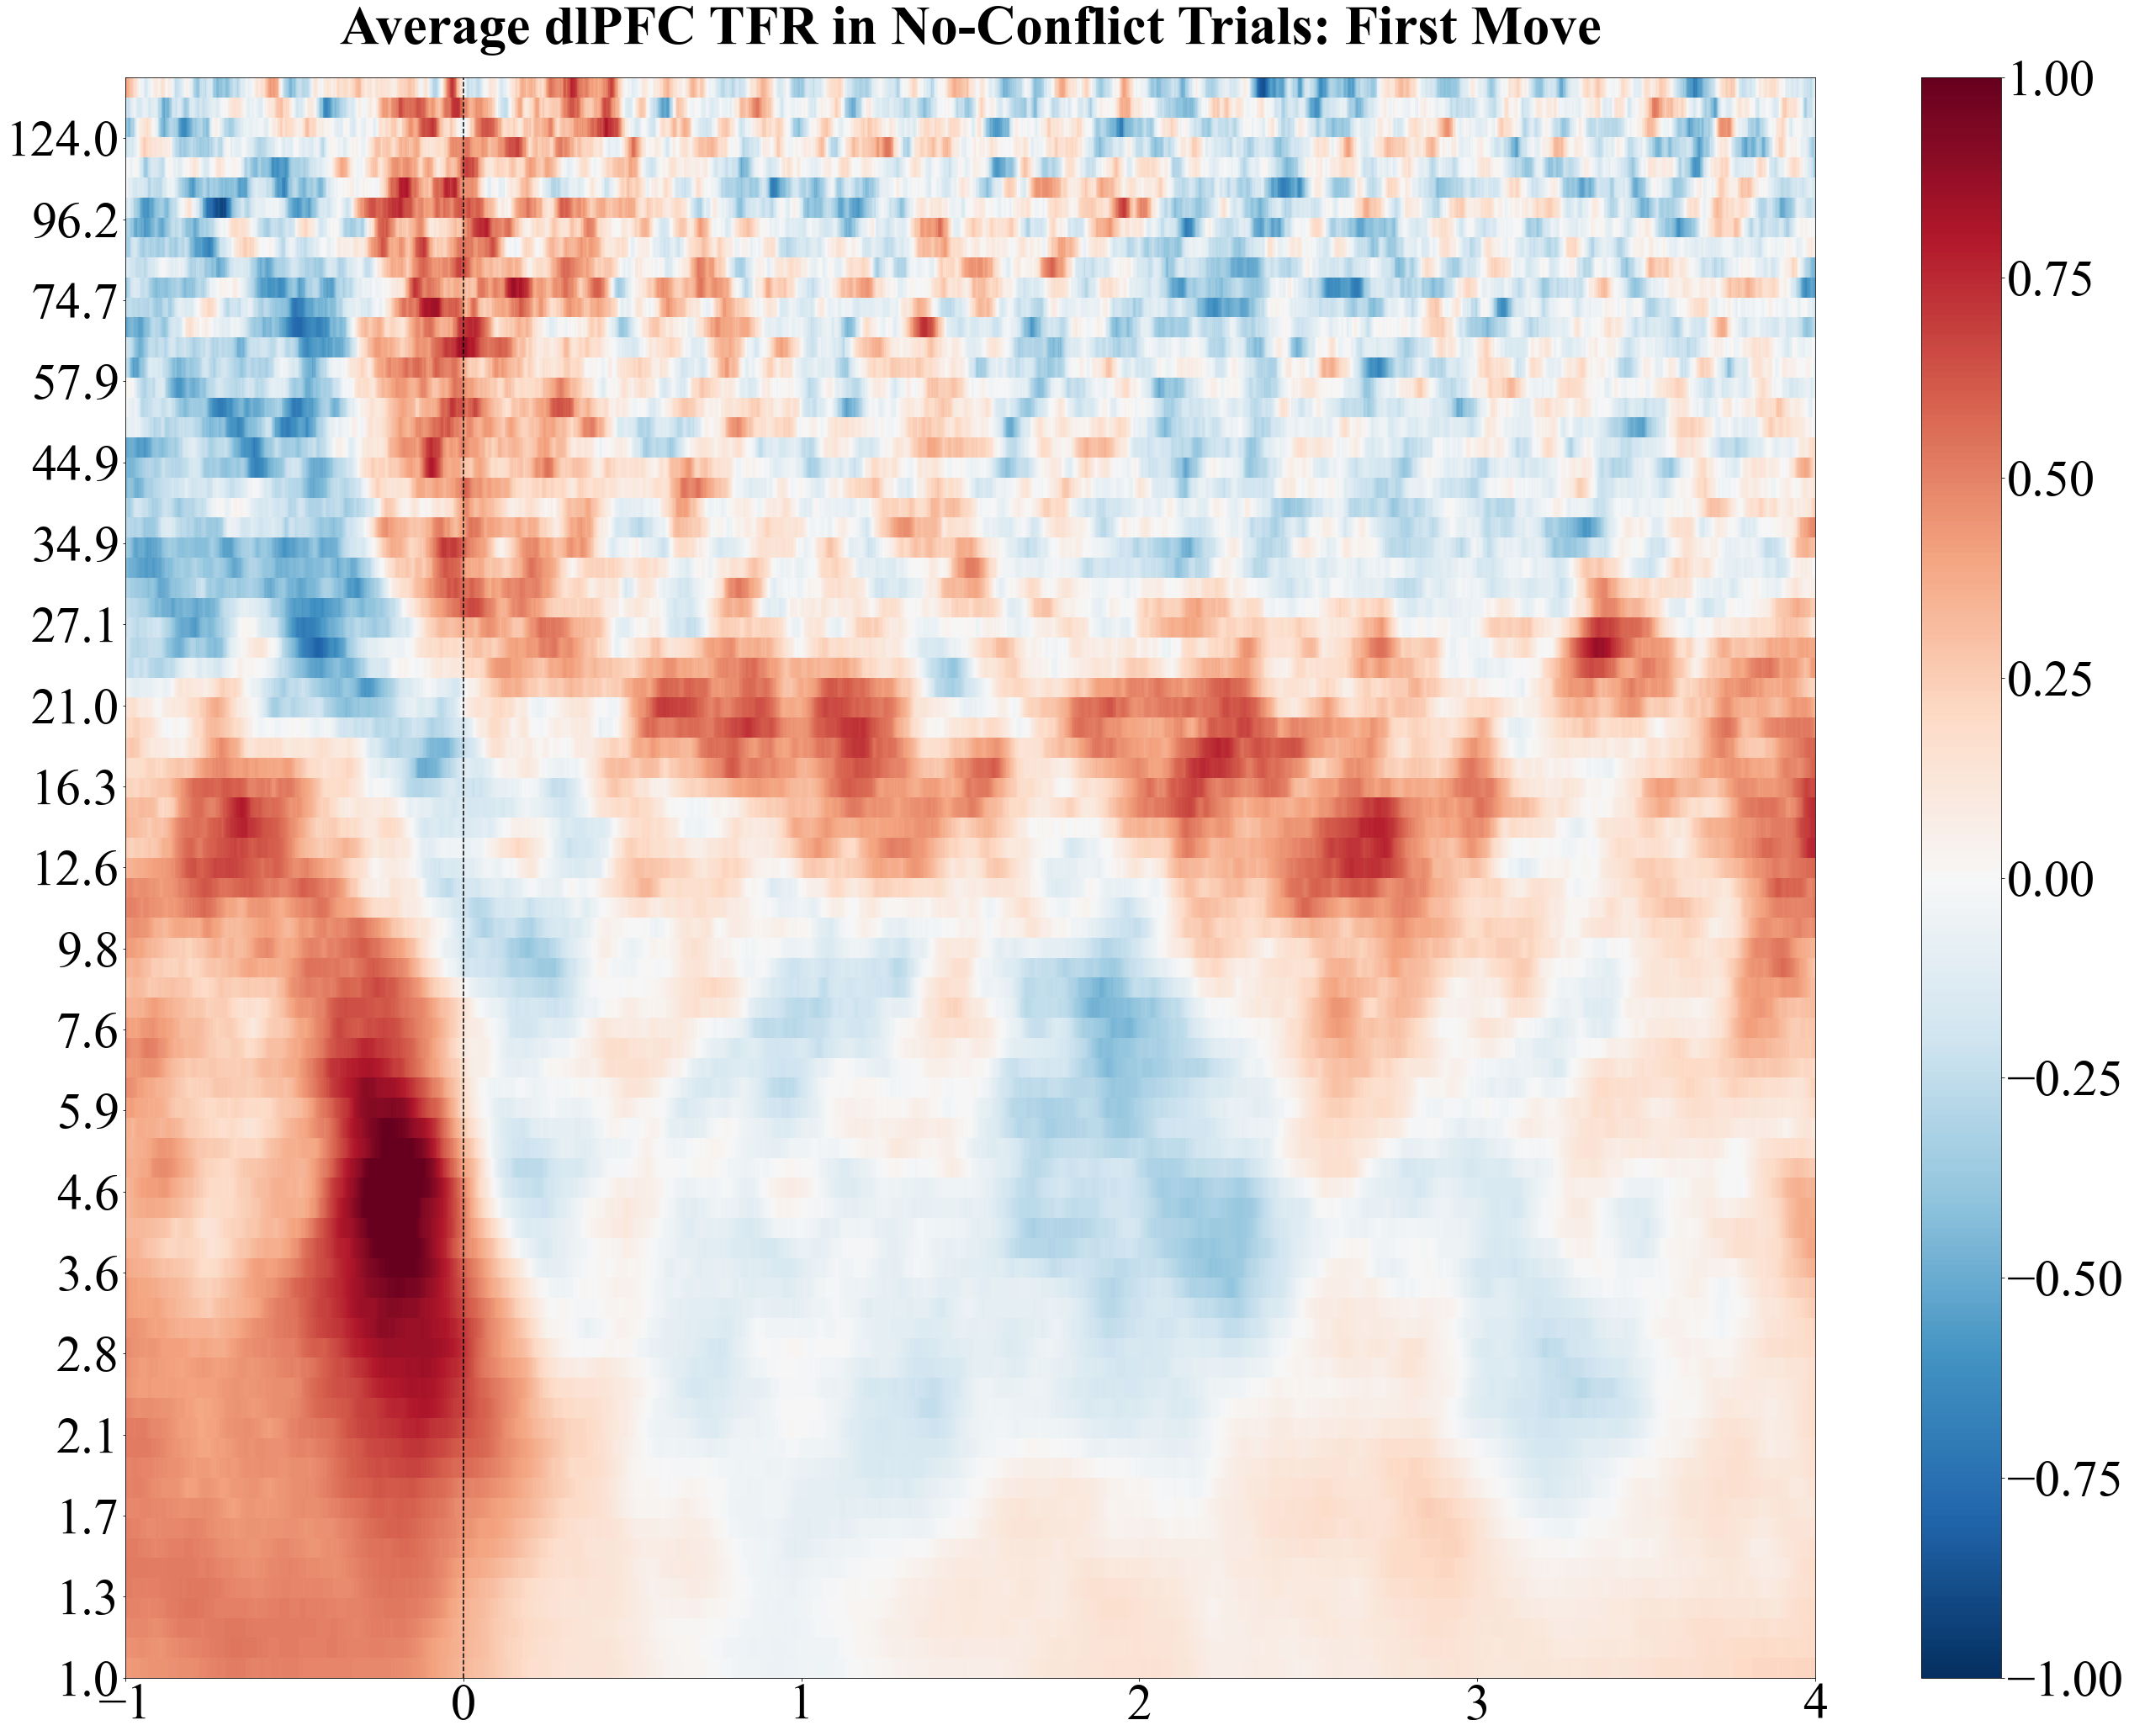

In [18]:
plot_allsub_averages(all_subs_average_dlpfc_noconflict, "Average dlPFC TFR in No-Conflict Trials: First Move", 'average_dlpfc_first_move_noconflict_all_subs.png')

## Insula

In [19]:
all_subs_average_insulas = calculate_first_move_average(sub_list, conditions, 'insula')
all_subs_average_insula_conflict = all_subs_average_insulas[0]
all_subs_average_insula_noconflict = all_subs_average_insulas[1]


Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/first_move/insula-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/first_move/insula-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/first_move/insula-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/first_move/insula-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg

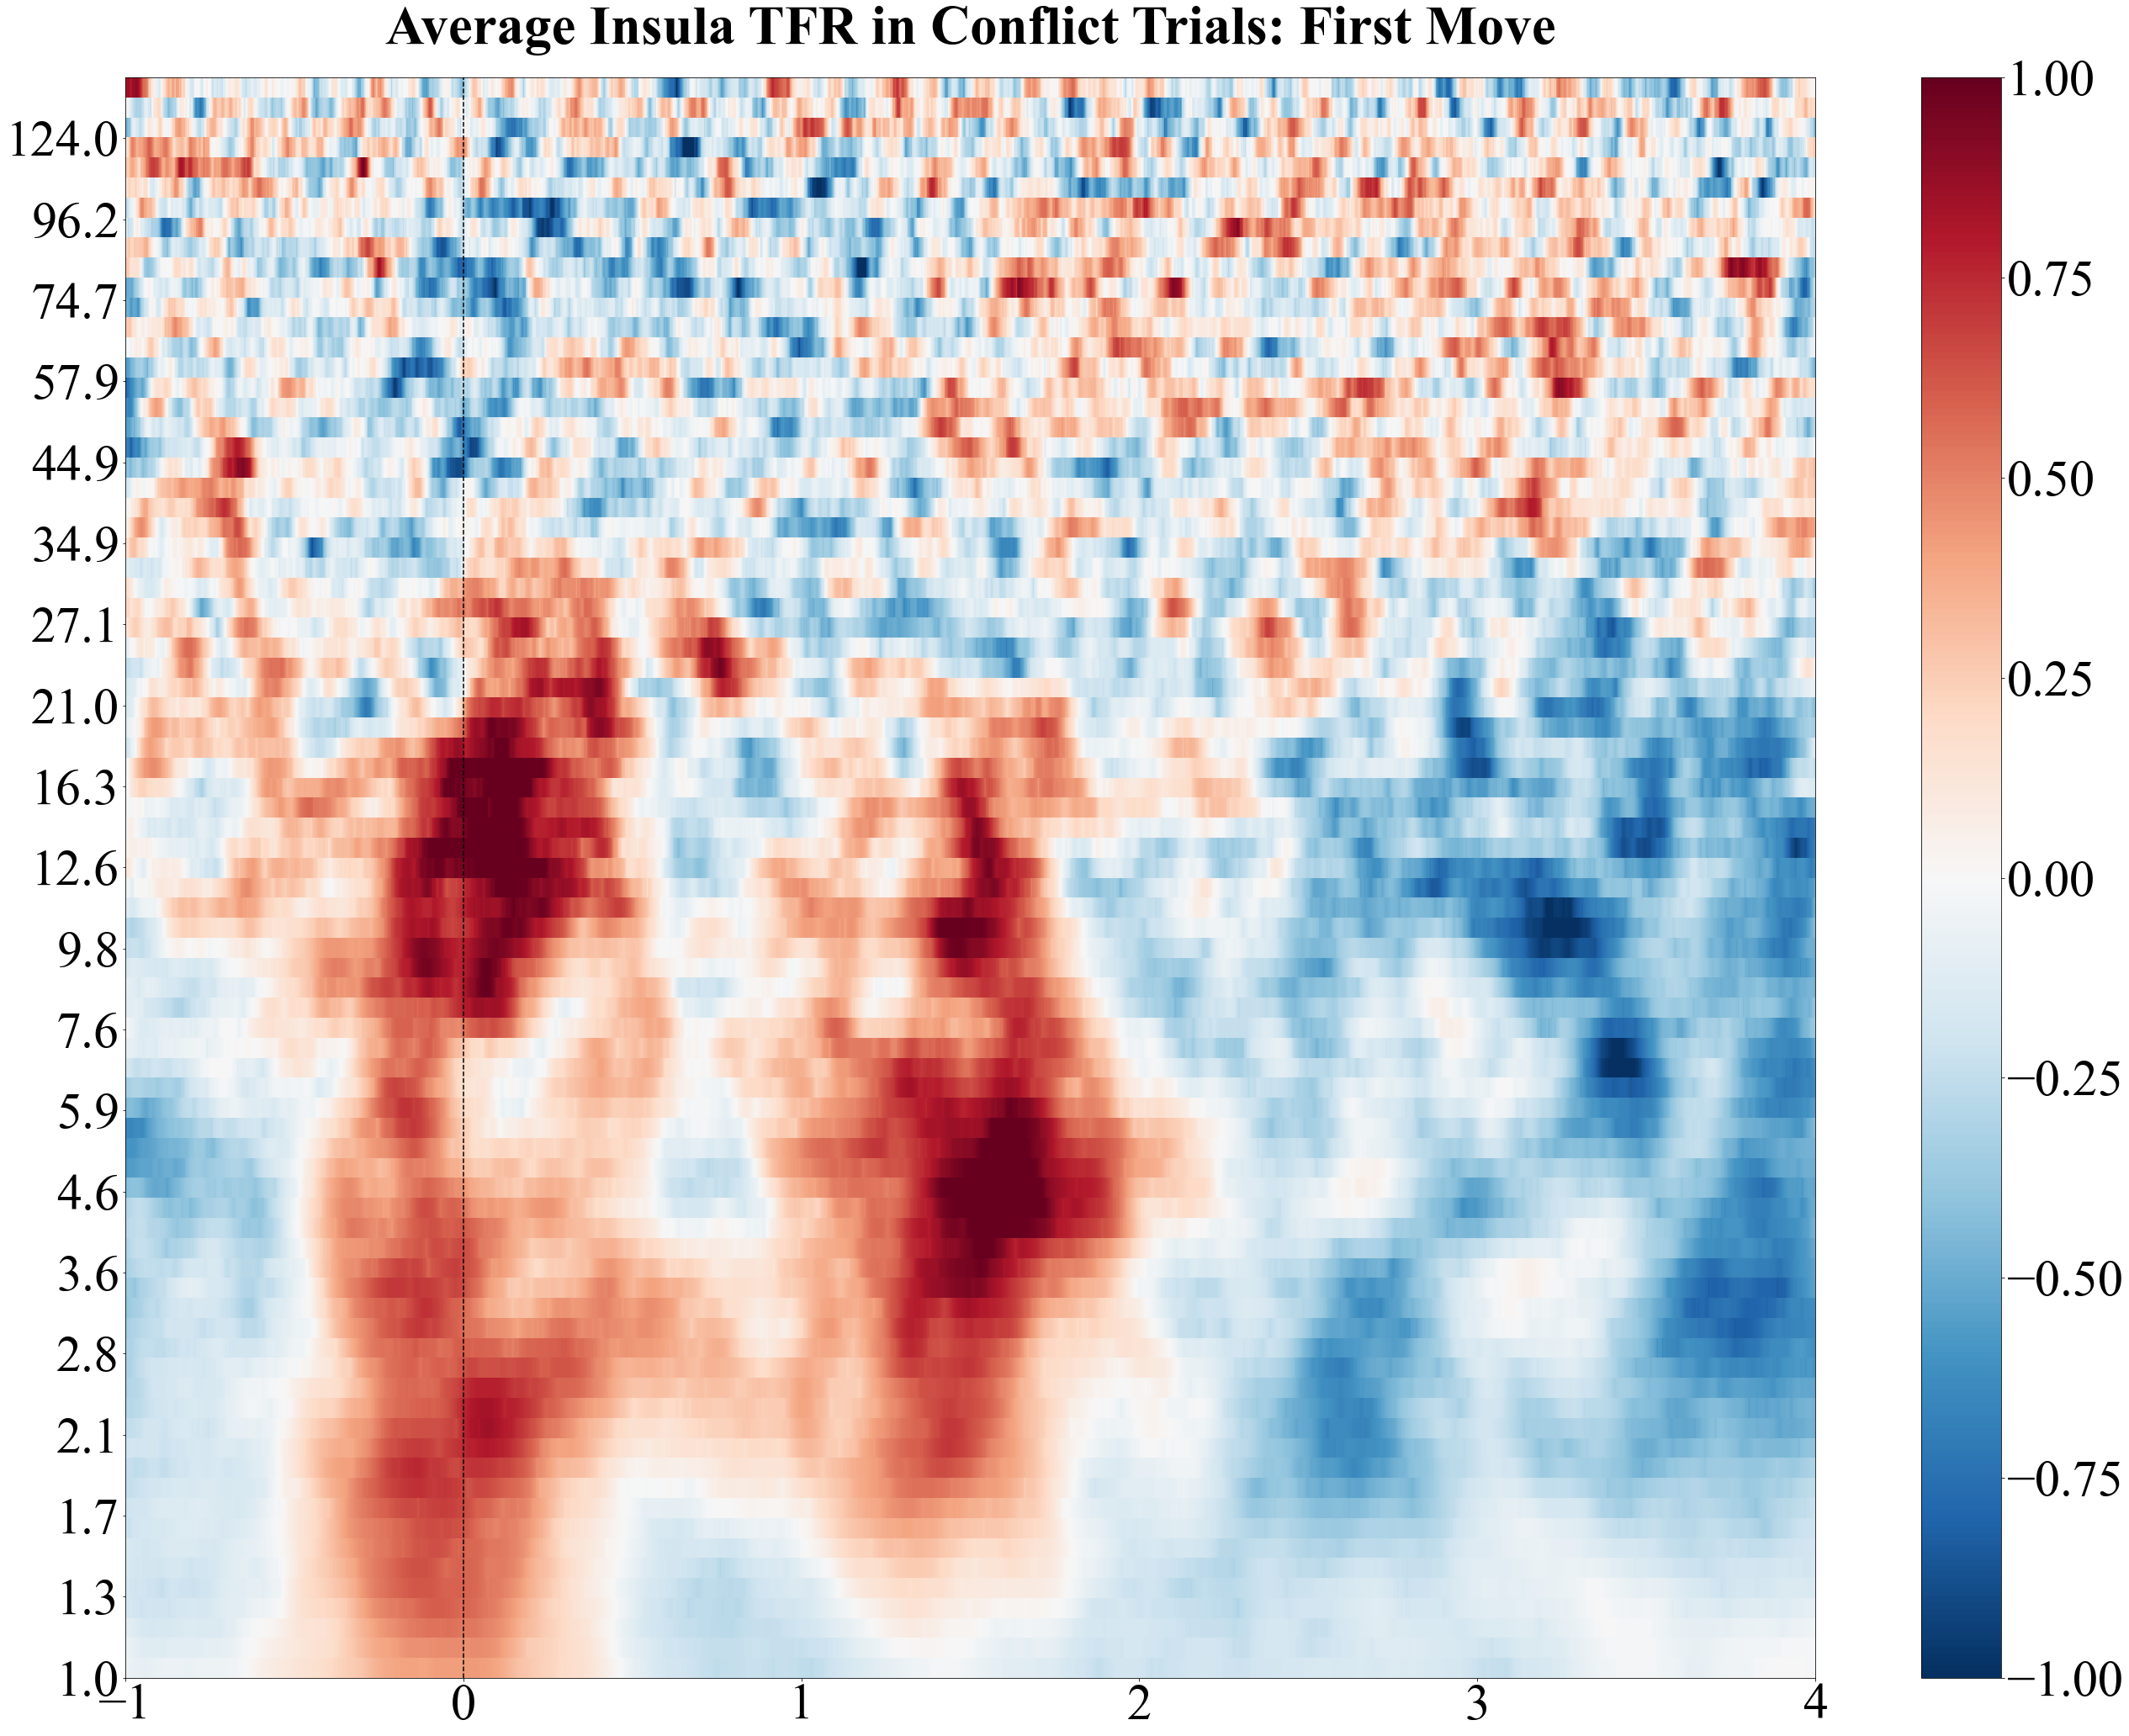

In [20]:
plot_allsub_averages(all_subs_average_insula_conflict, "Average Insula TFR in Conflict Trials: First Move", 'average_insula_first_move_all_subs.png')

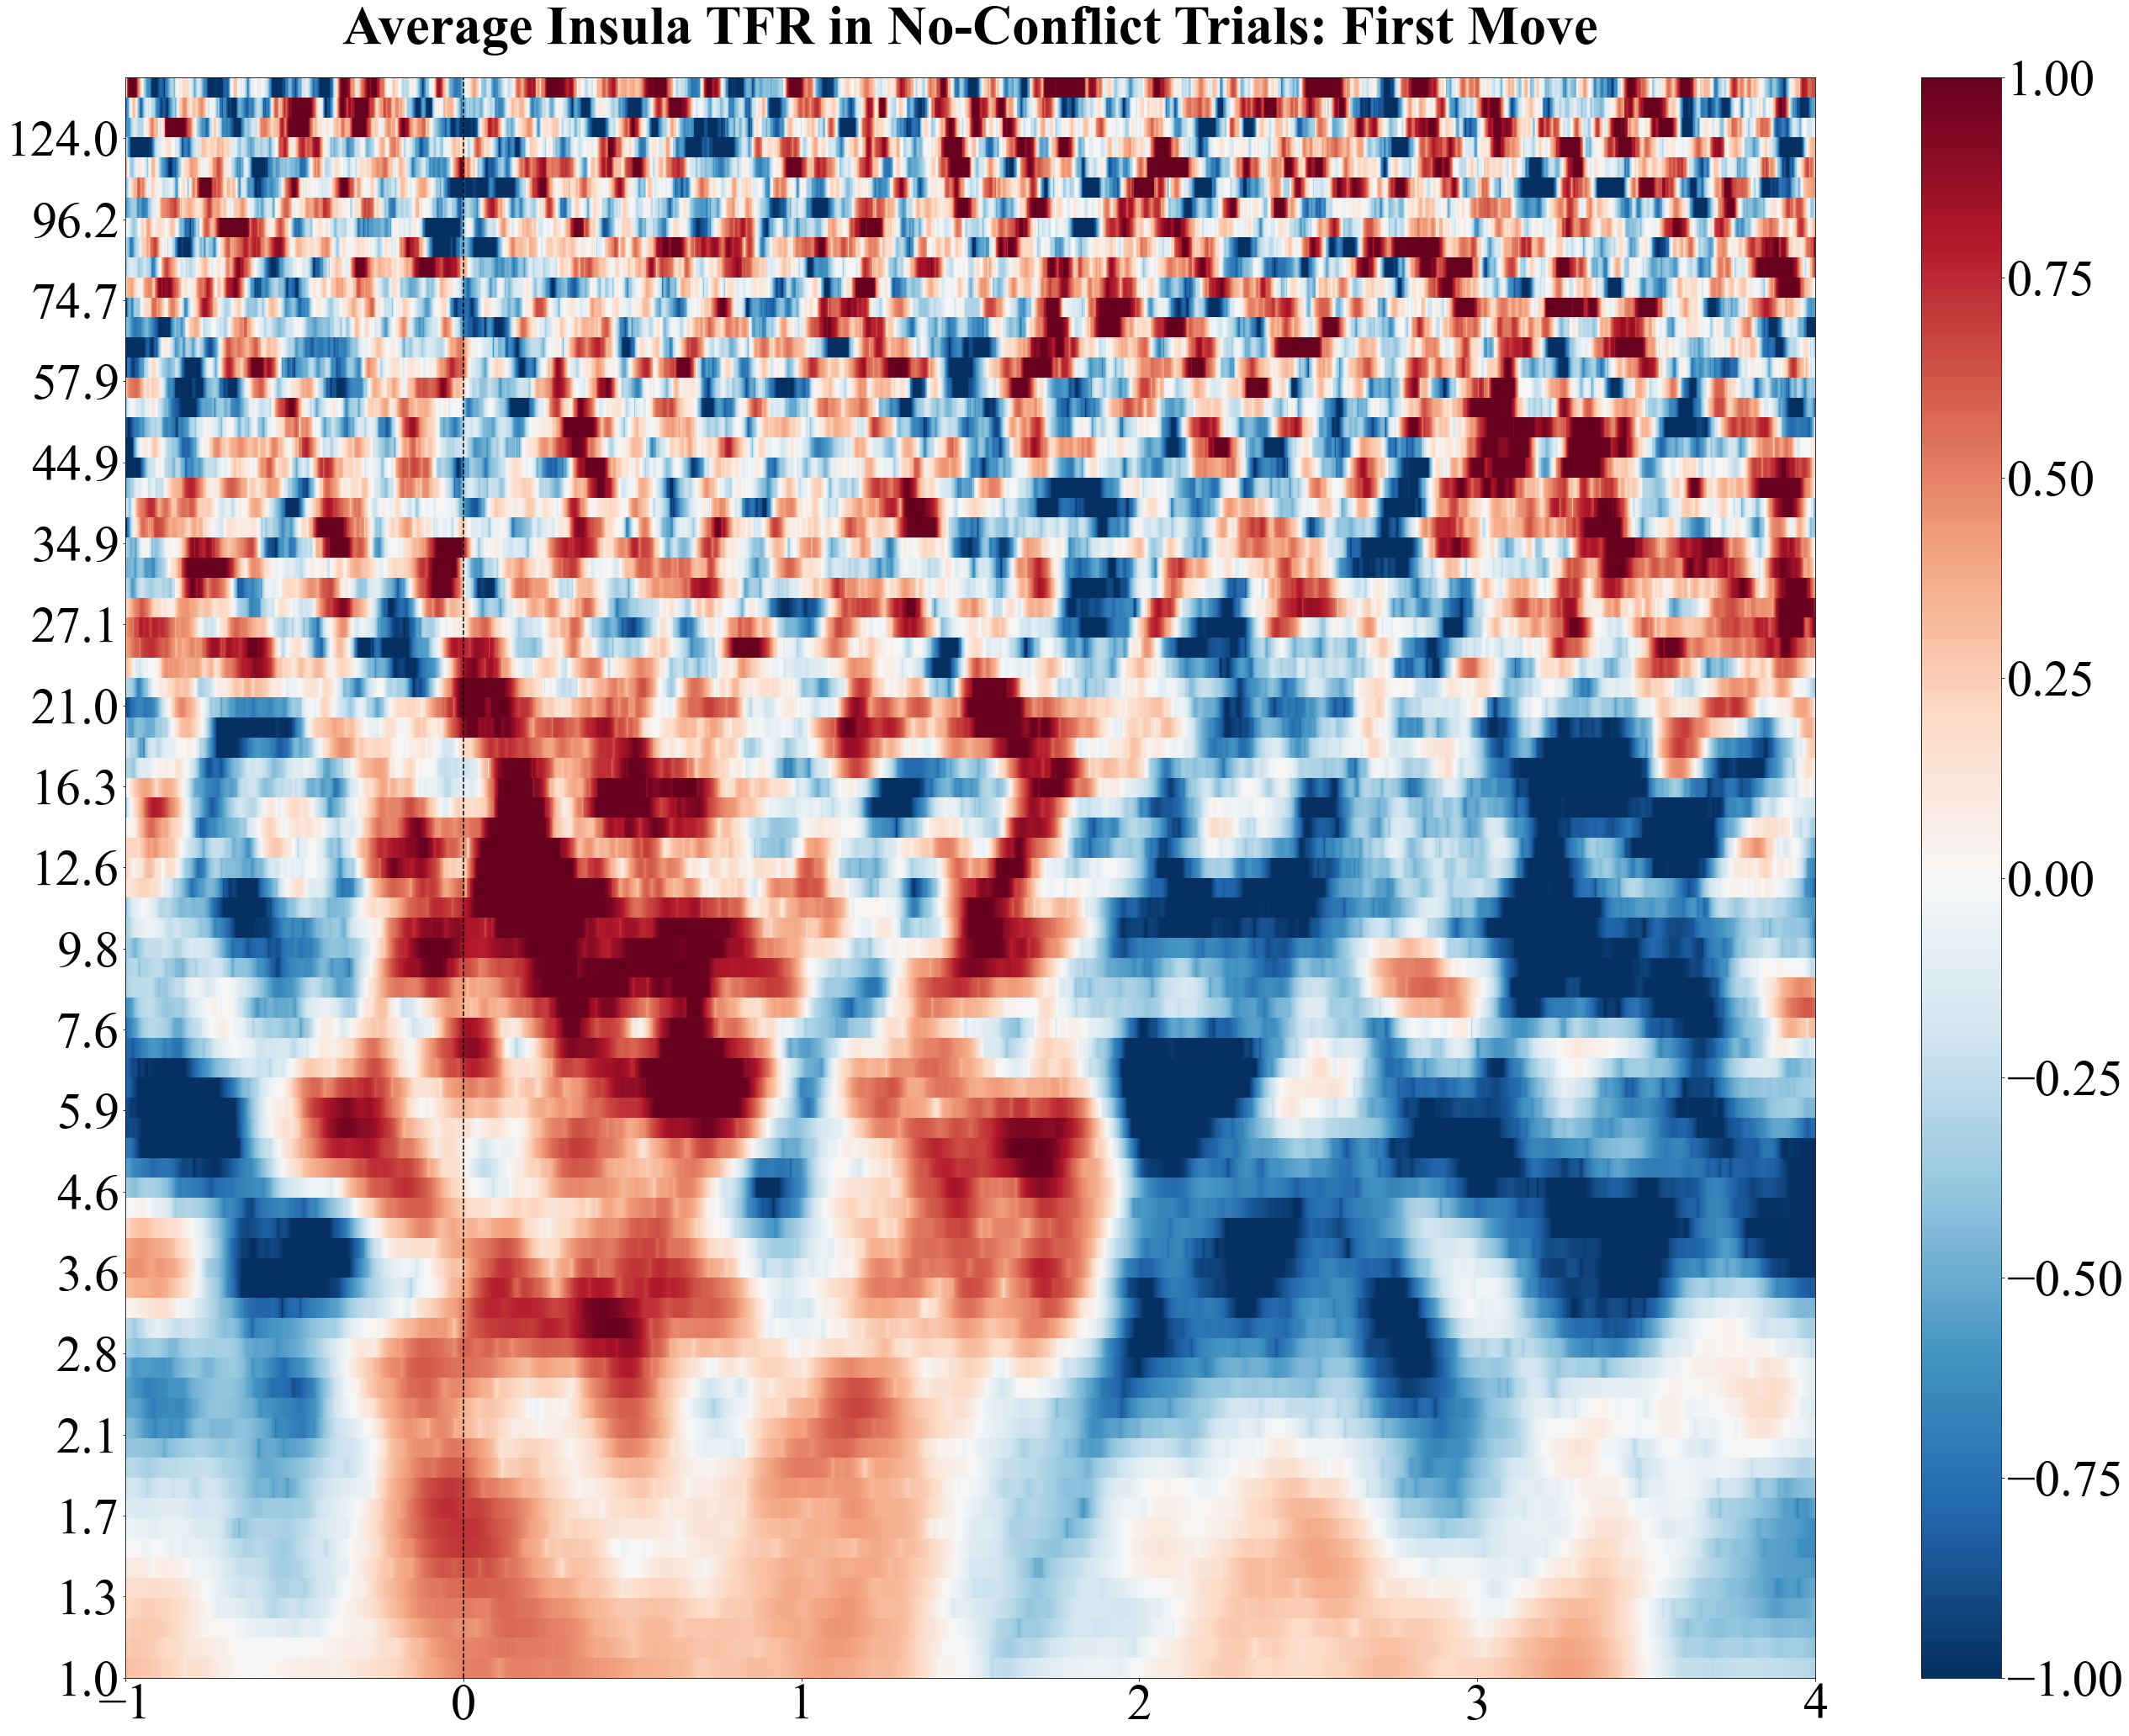

In [21]:
plot_allsub_averages(all_subs_average_insula_noconflict, "Average Insula TFR in No-Conflict Trials: First Move", 'average_insula_first_move_noconflict_all_subs.png')

## EC

In [22]:
all_subs_average_ecs = calculate_first_move_average(sub_list, conditions, 'ec')
all_subs_average_ec_conflict = all_subs_average_ecs[0]
all_subs_average_ec_noconflict = all_subs_average_ecs[1]


currently used subs: []
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/first_move/ec-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/first_move/ec-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/first_move/ec-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'BJH016', 'SLCH002']
currently used subs: ['BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH027/ieeg/first_move/ec-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'BJH016', 'SLCH002', 'BJH027']
Reading /home/brooke

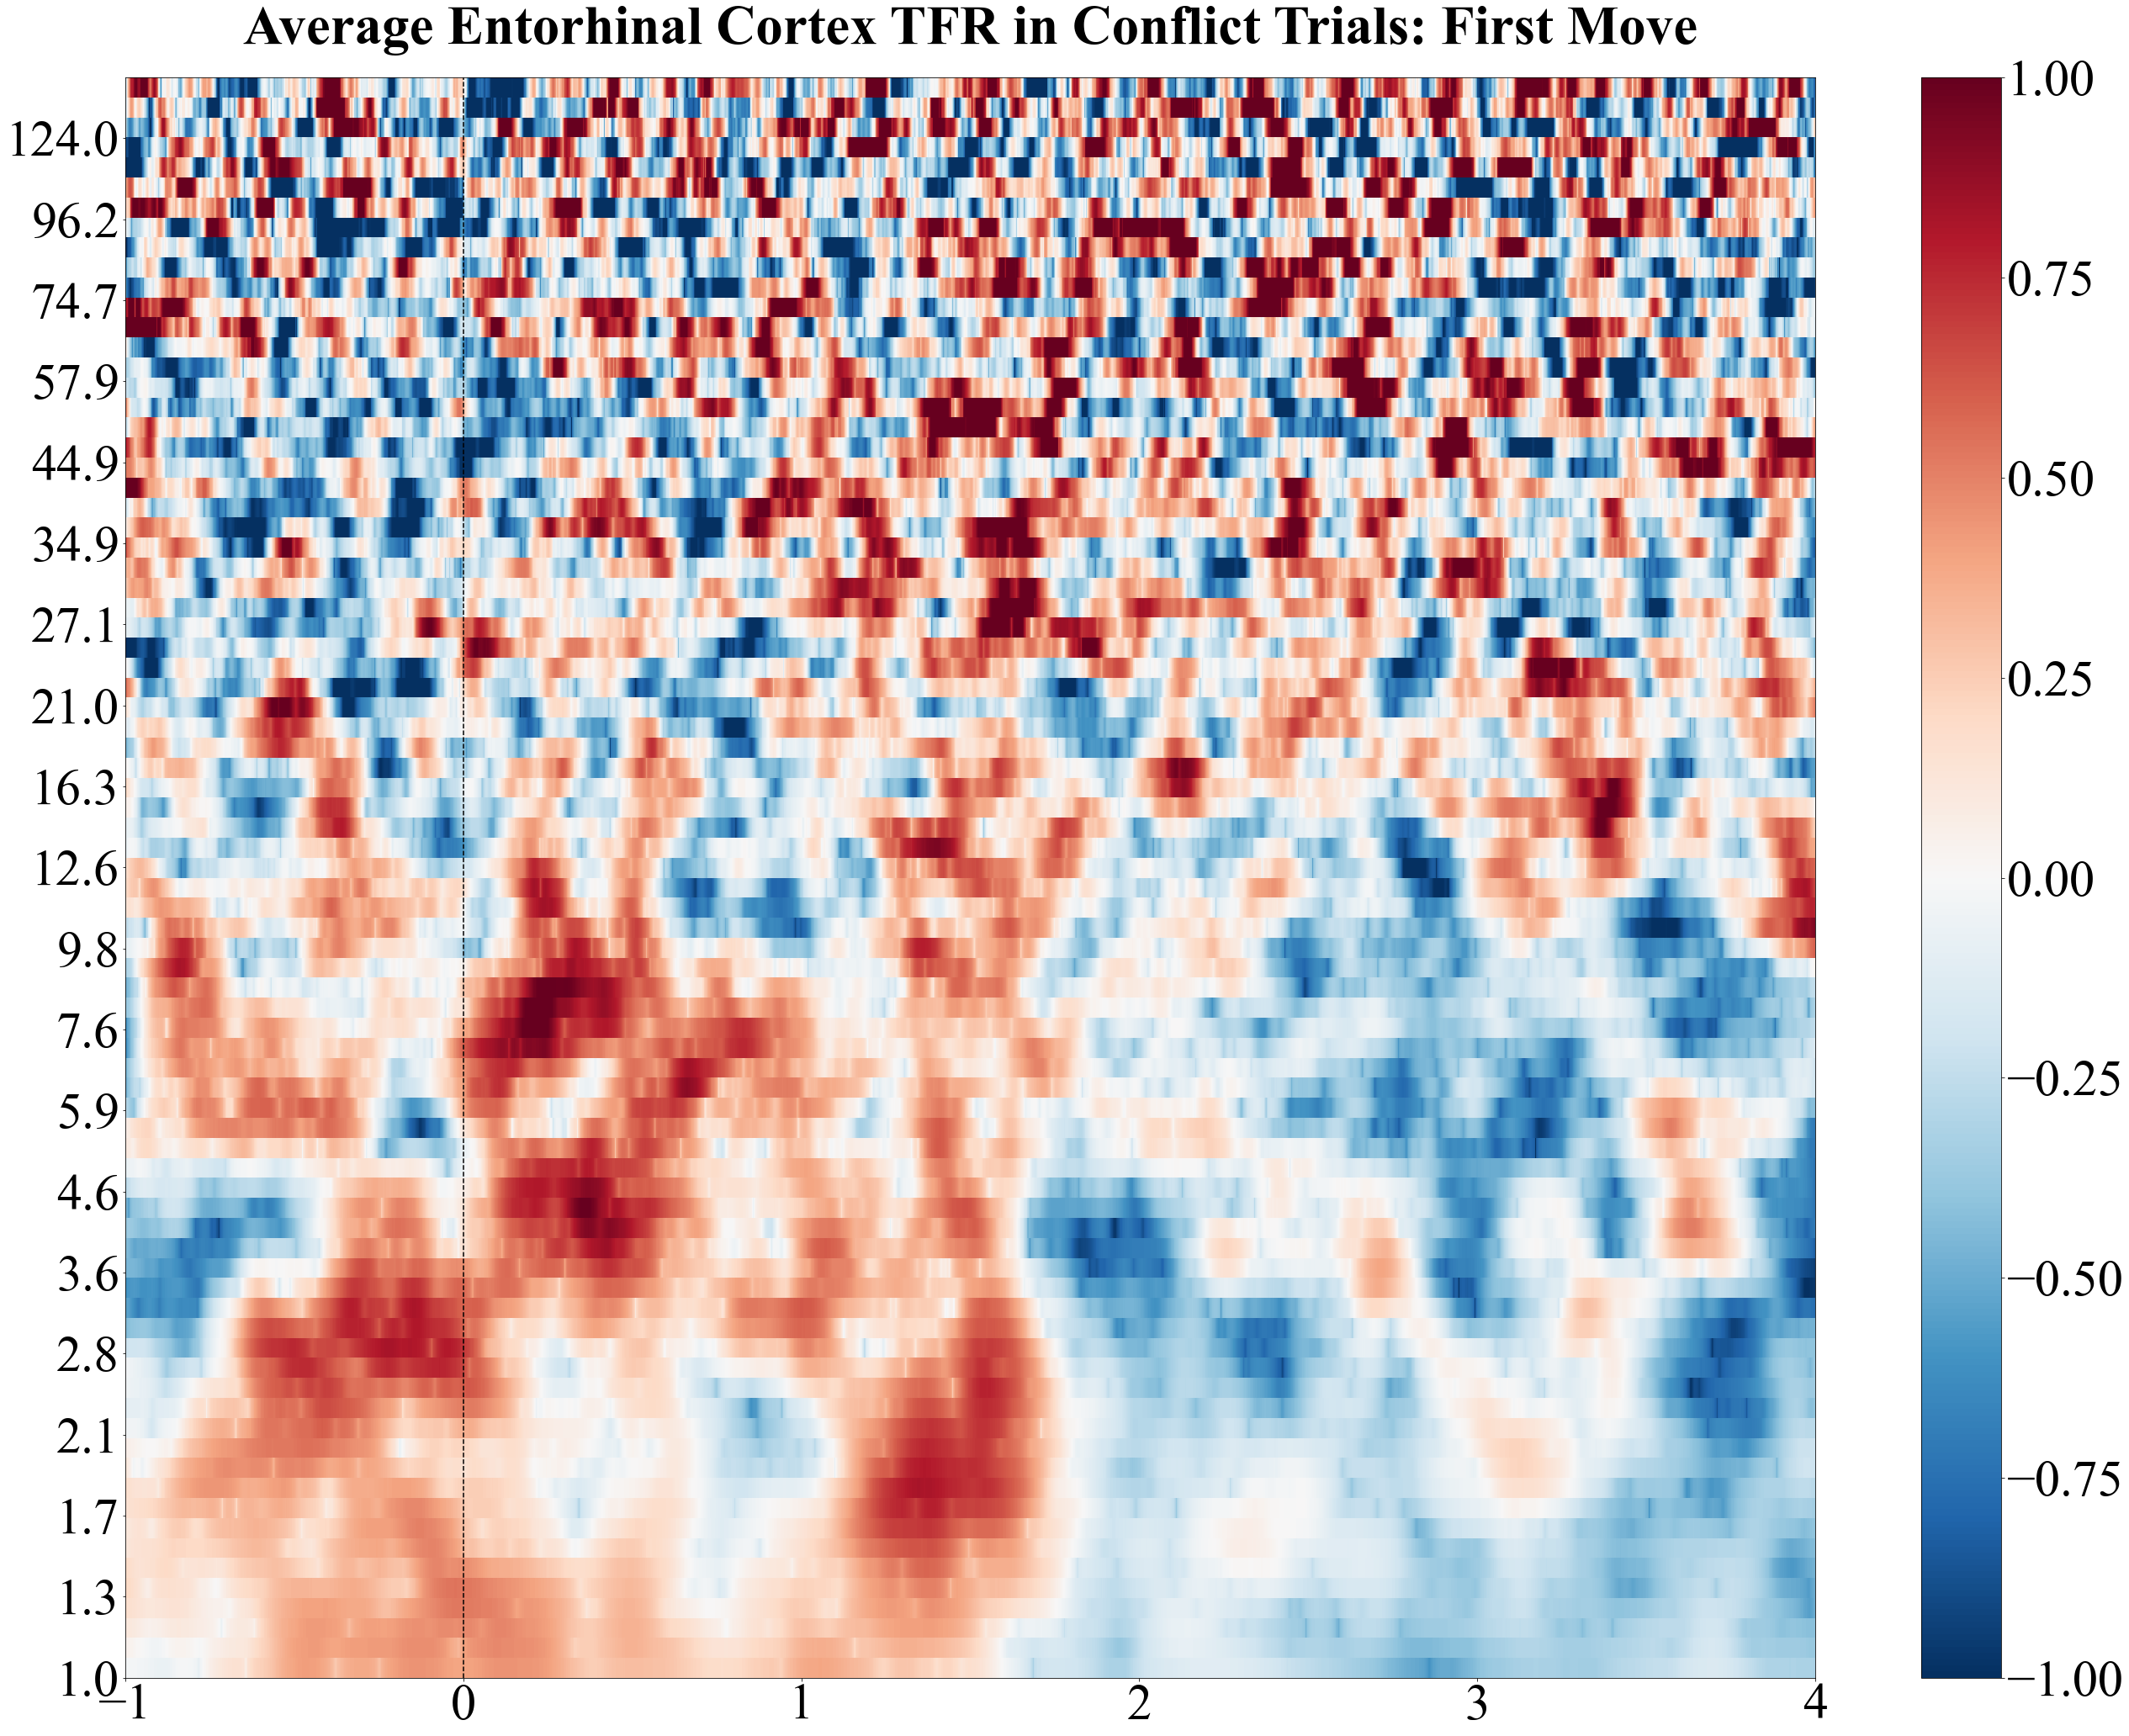

In [23]:
plot_allsub_averages(all_subs_average_ec_conflict, "Average Entorhinal Cortex TFR in Conflict Trials: First Move", 'average_ec_first_move_all_subs.png')

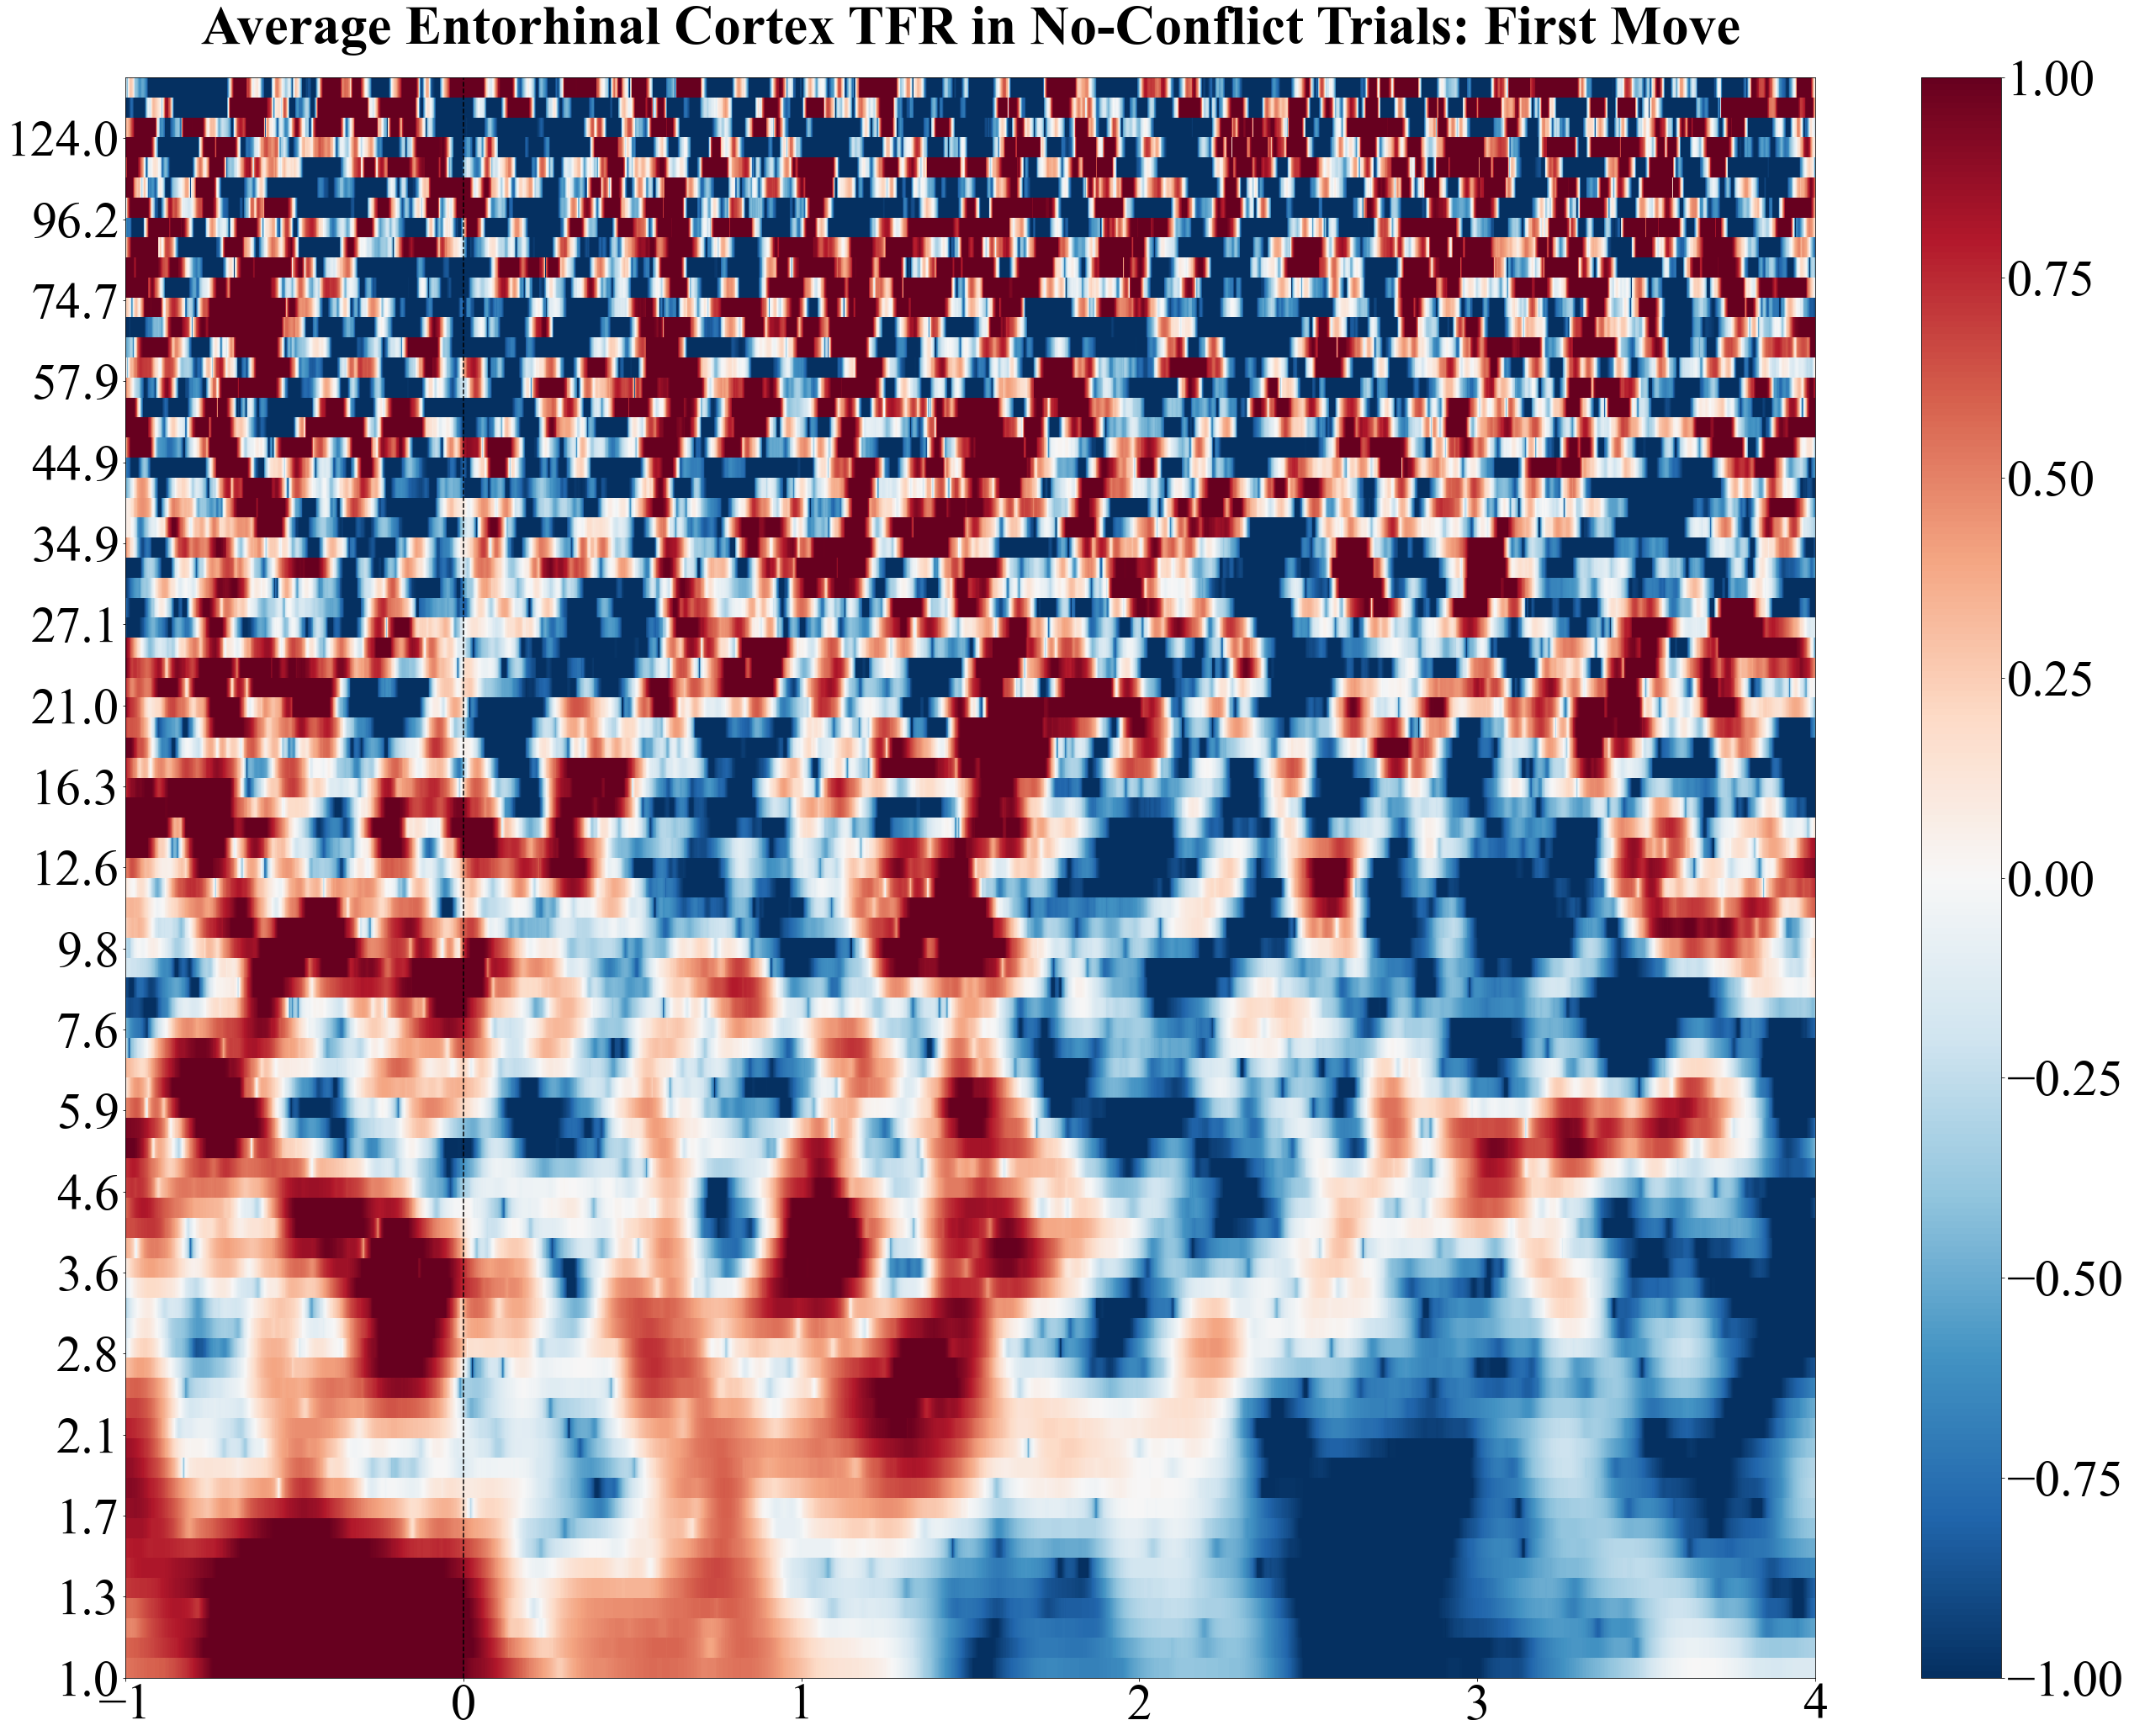

In [24]:
plot_allsub_averages(all_subs_average_ec_noconflict, "Average Entorhinal Cortex TFR in No-Conflict Trials: First Move", 'average_ec_first_move_noconflict_all_subs.png')